# this is about the RNASeq additional to the blueprint for the TE analysis 

# import pacakges

In [2]:
library(DESeq2)
library(data.table)
library(dplyr)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(clusterProfiler)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(ggplot2)
library(gridExtra)
library(IRdisplay)
library(ChIPpeakAnno)
library(sva)
library(IRdisplay)
library(ggpubr)
library(DiffBind)
library(Seurat)
library(kableExtra)
library(tidyverse)
library(clusterProfiler)
library(enrichplot)
library(readxl)
#library(umap)
library(corrplot)
library(ggrepel)
library(msigdbr)
library(ggraph)
library(tidygraph)
library(fgsea)
library(ggvenn)
library(ComplexHeatmap)
library(ggVennDiagram)
library(venneuler)
library(sva)
library(DT)
library(tools)
library(tidyverse)
library(RSQLite)

library(edgeR)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

options(width = 188)

base_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/'
data_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/' 
source('~/script/utils.r')
setwd(base_dir)


In [12]:
path = paste0(Sys.getenv('PATH'), ':', '/home/whu78/conda3/envs/feb24/bin:/home/whu78/conda3/envs/feb24/condabin:/hpcf/user_commands:/usr/NX/bin:/cm/local/apps/environment-modules/4.5.3/bin:/hpcf/lsf/lsf_prod/10.1/linux3.10-glibc2.17-x86_64/etc:/hpcf/lsf/lsf_prod/10.1/linux3.10-glibc2.17-x86_64/bin:/usr/lpp/mmfs/bin:/usr/lpp/mmfs/lib:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/usr/sbin:/cm/local/apps/environment-modules/4.5.3/bin:/usr/sbin:/sbin:/bin:/usr/bin:/etc:/usr/ucb:/usr/local/bin:/usr/local/local_dfs/bin:/usr/bin/X11:/usr/local/sas:/home/whu78/.local/bin:/home/whu78/bin')
path = unique(unlist(strsplit(path, ':')))
path = c(path, '/home/whu78/edirect/')
path = paste(path, collapse = ':')
Sys.setenv('PATH' = path)


# import blueprint rnaseq design tabel

In [5]:
dsn_bp = fread('../collab_Farhan/data/organized_sample_table.xls')
colnames(dsn_bp)
head(dsn_bp[, .(sample_name_id, sample_dir, R1, R2)], 1) 


[1] "sample_name"            "cell_type"              "SAMPLE_DESC_2"          "SAMPLE_DESC_3"          "R1"                     "R2"                     "count_file"            
 [8] "sample_dir"             "fastq_r1_trimmed"       "fastq_r2_trimmed"       "cutadapt_jobname"       "cutadapt_oo"            "cutadapt_eo"            "cutadapt_cmd"          
[15] "star_jobname"           "star_oo"                "star_eo"                "bam_prefix"             "bam_file"               "star_cmd"               "tecount_jobname"       
[22] "tecount_oo"             "tecount_eo"             "tecount_cmd"            "telocal_jobname"        "telocal_oo"             "telocal_eo"             "telocal_cmd"           
[29] "telocal_count_file_ori" "telocal_count_file"     "cmd"                    "tag"                    "cell_type_replication"  "sample_name_id"

sample_name_id
1 MEP1          
  sample_dir                                                                                                                                                                                                                
1 /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/Blueprint_EGA_Data_EGAD00001000745_Transcriptional_Diversity_Human_Blood_progenitors_Chen_etal_Science_2014/huw/Blueprint_C000WYB3_MEP_RNA_Seq_A1/
  R1                                                                                                                                                                                                                                                   
1 /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/Blueprint_EGA_Data_EGAD00001000745_Transcriptional_Diversity_Human_Blood_progenitors_Chen_etal_Science_2014/fastq3/EGAF00000413673/Blueprint_C000WYB3_MEP_RNA_Seq_A1_r1.fq.gz
  R2                                                                                                                                                                                                                                                  
1 /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/Blueprint_EGA_Data_EGAD00001000745_Transcriptional_Diversity_Human_Blood_progenitors_Chen_etal_Science_2014/fastq/EGAF00000413674/Blueprint_C000WYB3_MEP_RNA_Seq_A1_r2.fq.gz

In [6]:
cell_types = c( 'HSC', 'MPP', 'CMP', 'GMP', 'MEP', 'CLP', 'EB', 'MK' )
dsn_bp[, cell_type := factor(cell_type, levels = cell_types)]
table(dsn_bp$cell_type)



HSC MPP CMP GMP MEP CLP  EB  MK 
  8   9   3   3   4  15  21  21 

# bloodChIP extra

In [7]:
dsn = fread('/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/flist')
dsn[, donor := unlist(strsplit(.SD$sample_name, '-'))[1], by = 1:nrow(dsn)]
dsn[, cell_type := unlist(strsplit(sample_name, '-'))[2], by = 1:nrow(dsn)]
dsn[grep('^\\d+', donor), donor := paste0('D', donor)]
dsn[, sample_dir := paste0(data_dir, donor, '_', cell_type)]
dsn[, sample_name := basename(sample_dir)] 
head(dsn)


gsm_id     sample_name donor cell_type sample_dir                                                                                 
1 GSM1915578 D1022_B     D1022 B         /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/D1022_B   
2 GSM1915579 D1022_CD4T  D1022 CD4T      /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/D1022_CD4T
3 GSM1915580 D1022_CD8T  D1022 CD8T      /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/D1022_CD8T
4 GSM1915581 D1022_NK    D1022 NK        /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/D1022_NK  
5 GSM1915582 D2596_B     D2596 B         /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/D2596_B   
6 GSM1915583 D2596_CD4T  D2596 CD4T      /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/D2596_CD4T

In [8]:
dsn[, srx_ids := {system(paste0('esearch -db sra -query "', gsm_id, '" | efetch -format docsum | accn-at-a-time | grep -i srx | tr [:lower:] [:upper:] | tr "\n" "," '), intern = T)}, 
      by = 1:nrow(dsn)]
dsn[, srr_ids := {system(paste0('esearch -db sra -query "', gsm_id, '" | efetch -format docsum | accn-at-a-time | grep -i srr | tr [:lower:] [:upper:] | tr "\n" "," '), intern = T)}, 
      by = 1:nrow(dsn)]
dsn[, srx_ids := sub(',$', '', srx_ids)]
dsn[, srr_ids := sub(',$', '', srr_ids)]
#fwrite(dsn, file = 'dsn_gse74246_v1.xls', sep = '\t')
      

In [9]:
dsn = fread('dsn_gse74246_v1.xls')
tmp = dsn[, .(srr_id = unlist(tstrsplit(srr_ids, ','))), by = 'sample_name']
dsn = merge(dsn, tmp, by = 'sample_name', all.x = T) 
head(dsn)


sample_name gsm_id     donor cell_type sample_dir                                                                                  srx_ids    srr_ids    srr_id    
1 D1022_B     GSM1915578 D1022 B         /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/D1022_B    SRX1363166 SRR2753073 SRR2753073
2 D1022_CD4T  GSM1915579 D1022 CD4T      /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/D1022_CD4T SRX1363167 SRR2753074 SRR2753074
3 D1022_CD8T  GSM1915580 D1022 CD8T      /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/D1022_CD8T SRX1363168 SRR2753075 SRR2753075
4 D1022_NK    GSM1915581 D1022 NK        /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/D1022_NK   SRX1363169 SRR2753076 SRR2753076
5 D2596_B     GSM1915582 D2596 B         /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/D2596_B    SRX1363170 SRR2753077 SRR2753077
6 D2596_CD4T  GSM1915583 D2596 CD4T      /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/GSE74246/D2596_CD4T SRX1363171 SRR2753078 SRR2753078

In [10]:
dsn[, sample_dir := paste0(sample_dir, '/')] 

# download fastq

In [13]:
dsn[, prefetch_cmd := paste0('prefetch ',     srr_id, ' -O ', sample_dir, ' --max-size 40g')]
dsn[, fastqdump_cmd:= paste0('cd ', sample_dir, ' && fasterq-dump ', srr_id, ' --outdir ', sample_dir)]

# if single end seq
dsn[, dump_r := paste0(sample_dir,  '/', srr_id, '.fastq')]
# if double end seq
dsn[, dump_r1 := paste0(sample_dir, '/', srr_id, '_1.fastq')] 
dsn[, dump_r2 := paste0(sample_dir, '/', srr_id, '_2.fastq')]

dsn[, gz_r_cmd := paste0(' gzip ', dump_r, ' &' )]
dsn[, gz_r1_cmd := paste0(' gzip ', dump_r1, ' &' )]
dsn[, gz_r2_cmd := paste0(' gzip ', dump_r2, ' &' )]

dsn[, r_fastq_gz := paste0(dump_r, '.gz')]
dsn[, r1_fastq_gz := paste0(dump_r1, '.gz')]
dsn[, r2_fastq_gz := paste0(dump_r2, '.gz')]


In [15]:
file.exists(dsn$r1_fastq_gz)
file.exists(dsn$r2_fastq_gz)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[37] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[73] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[37] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[73] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [27]:
write(dsn[, gz_r1_cmd], file = paste0('run_rnaseq_r1_zip.sh'))
write(dsn[, gz_r2_cmd], file = paste0('run_rnaseq_r2_zip.sh'))

# merge lane

In [16]:
dsn[, nn := nrow(.SD), by = 'sample_name']
table(dsn$nn)


 1  2 
80  2 

In [ ]:
dsn[, nn := nrow(.SD), by = 'sample_name']
dsn[, sample_dir2 := paste0(base_dir, 'rnaseq/', sample_name, '/')]
dsn[, r1_sample := paste0(sample_dir2, sample_name, '_R1.fastq.gz')]
dsn[, r2_sample := paste0(sample_dir2, sample_name, '_R2.fastq.gz')]

dsn[, {dir.create(sample_dir2, showWarnings = F, recursive = T)}, by = 1:nrow(dsn)] 
dsn[, {if(.SD$nn == 1){createLink(link = .SD$r1_sample, target = .SD$r1_fastq_gz)}}, by = 1:nrow(dsn)] 
dsn[, {if(.SD$nn == 1 & file.exists(.SD$r2_fastq_gz) & file.size(.SD$r2_fastq_gz) > 1000){createLink(link = .SD$r2_sample, target = .SD$r2_fastq_gz)}}, by = 1:nrow(dsn)] 


In [21]:
PP = 'rnaseq'
dsn[, merge_r1_jobname := paste0('merge_r1_', sample_name)]
dsn[, merge_r1_oo := paste0(sample_dir2, merge_r1_jobname, '_out')]
dsn[, merge_r1_eo := paste0(sample_dir2, merge_r1_jobname, '_err')]
dsn[, merge_r1_cmd := paste0('bsub -J ', merge_r1_jobname, ' -n 4 -o ', merge_r1_oo, ' -e ', merge_r1_eo)]
dsn[, merge_r1_cmd := paste0(merge_r1_cmd, ' " cat ', paste(.SD$r1_fastq_gz, collapse = ' '), ' > ', r1_sample, '"'), by = 'sample_name'] 

dsn[, merge_r2_jobname := paste0('merge_r2_', sample_name)]
dsn[, merge_r2_oo := paste0(sample_dir, merge_r2_jobname, '_out')]
dsn[, merge_r2_eo := paste0(sample_dir, merge_r2_jobname, '_err')]
dsn[, merge_r2_cmd := paste0('bsub -J ', merge_r2_jobname, ' -n 4 -o ', merge_r2_oo, ' -e ', merge_r2_eo)]
dsn[, merge_r2_cmd := paste0(merge_r2_cmd, ' " cat ', paste(.SD$r2_fastq_gz, collapse = ' '), ' > ', r2_sample, '"'), by = 'sample_name'] 

dsn_merged = dsn[!duplicated(sample_dir), ]


In [23]:
dsn_sample = dsn[!duplicated(sample_name) , ]
dsn_sample[, sample_dir := sample_dir2] 


In [22]:
write(dsn_sample, file = 'run_rnaseq_merge_r1.sh')
write(dsn_sample, file = 'run_rnaseq_merge_r2.sh')


In [24]:
fwrite(dsn_sample, file = 'dsn_rnaseq_sample.tsv')

# cutadapt

In [26]:
dsn_sample[, sede := 'se']
dsn_sample[file.exists(r2_fastq_gz) & file.size(r2_fastq_gz) > 1000, sede := 'de']

In [27]:
# module load cutadapt/4.4

dsn_sample[, r1_trimmed := paste0(sample_dir2, sample_name, '_R1_trimmed.fa.gz')]
dsn_sample[, r2_trimmed := paste0(sample_dir2, sample_name, '_R2_trimmed.fa.gz')]
dsn_sample[, cutadapt_jobname := paste0('cuta_', sample_name)]
dsn_sample[, cutadapt_oo := paste0(sample_dir2, sample_name, '_', cutadapt_jobname, '_out')]
dsn_sample[, cutadapt_eo := paste0(sample_dir2, sample_name, '_', cutadapt_jobname, '_err')]
dsn_sample[, cutadapt_cmd := paste0('bsub -J ', cutadapt_jobname, ' -n 10 -o ', cutadapt_oo, ' -e ', cutadapt_eo)]

# if paired end sequencing 
dsn_sample[sede == 'de', cutadapt_cmd := paste0(cutadapt_cmd, ' " cutadapt -o ', r1_trimmed, ' -p ', r2_trimmed, ' ', r1_sample, ' ', r2_sample, '"')]

# if single end sequencing 
dsn_sample[sede == 'se', cutadapt_cmd := paste0(cutadapt_cmd, ' " cutadapt -o ', r1_trimmed, ' ', r1_sample, '"')]

write(dsn_sample[, cutadapt_cmd], file = paste0('run_', PP, '_cutadapt.sh'))


# align

In [31]:
species = 't2t'
dsn_sample[, fname_pre := paste0(sample_dir2, sample_name, '_', species, '_')]

In [32]:
# module load star/2.7.10a
REFERENCE_GENOME="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF"
GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf"
TE_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf"

dsn_sample[, star_jobname := paste0('star_', sample_name)]
dsn_sample[, star_oo := paste0(sample_dir2, 'star_', sample_name, '_out')]
dsn_sample[, star_eo := paste0(sample_dir2, 'star_', sample_name, '_err')]
dsn_sample[, bam_prefix := fname_pre]
dsn_sample[, bam_file := paste0(bam_prefix, 'Aligned.sortedByCoord.out.bam')]
#alignments/A549_0_1 Aligned.sortedByCoord.out.bam

dsn_sample[, star_cmd := paste0('bsub -J ', star_jobname, ' -o ', star_oo, ' -e ', star_eo, ' -P ', PP, ' -n 30 -R "rusage[mem=5GB]" ')]
#dsn_sample[, star_cmd := paste0(star_cmd, ' -w ', cutadapt_jobname)]
dsn_sample[, star_cmd := paste0(star_cmd, ' -W 90')]
dsn_sample[, star_cmd := paste0(star_cmd, ' " STAR --genomeDir ', REFERENCE_GENOME)] 
dsn_sample[, star_cmd := paste0(star_cmd, ' --runThreadN 28 --outSAMtype BAM SortedByCoordinate --outFilterMultimapNmax 1000 --outSAMmultNmax 1 ')]
dsn_sample[, star_cmd := paste0(star_cmd, ' --outFilterMismatchNmax 3 --outMultimapperOrder Random --winAnchorMultimapNmax 1000 --alignEndsType EndToEnd ')]
dsn_sample[, star_cmd := paste0(star_cmd, ' --alignIntronMax 1 --alignMatesGapMax 350 --quantMode TranscriptomeSAM --readFilesIn ', r1_trimmed, ' ', r2_trimmed, ' ')]
dsn_sample[, star_cmd := paste0(star_cmd, ' --readFilesCommand zcat --outFileNamePrefix ', bam_prefix, '"')]

write(dsn_sample[, star_cmd], file = paste0(base_dir, 'run_rnaseq_star.sh'))



In [42]:
round(file.size(dsn_sample$bam_file) / 1000000000, 3)

[1] 0.616 0.900 0.746 0.542 1.418 1.456 1.383 1.494 0.927 1.475 0.761 0.585 0.662 0.945 1.448 1.697 1.393 1.332 0.859 1.300 1.089 1.293 1.756 2.273 2.306 1.592 2.692 2.157 1.530 0.901
[31] 0.688 0.804 2.334 0.869 0.754 0.769 0.833 0.416 1.433 0.906 0.770 1.037 1.196 0.634 1.342 0.726 0.540 1.370 0.888 1.850 1.471 1.805 1.161 1.460 1.757 1.511 1.741 1.674 1.191 1.653
[61] 1.687 2.436 0.830 1.332 1.602 1.526 1.157 2.175 1.228 2.098 0.871 1.044 0.836 1.235 0.960 0.660 1.629 0.256 0.924 1.329 1.107

# TEcount

In [37]:
GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf"
TE_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf"
bin_tecount = '/home/whu78/conda3/envs/te/bin/'

dsn_sample[, tecount_jobname := paste0('tecount_', sample_name)]
dsn_sample[, tecount_oo := paste0(sample_dir2, 'tecount_', sample_name, '_out')]
dsn_sample[, tecount_eo := paste0(sample_dir2, 'tecount_', sample_name, '_err')]

dsn_sample[, tecount_cmd := paste0('bsub -J ', tecount_jobname, ' -n 15 -o ', tecount_oo, ' -e ', tecount_eo, ' -P ', PP, ' -R "rusage[mem=5GB]" ')]
dsn_sample[, tecount_cmd := paste0(tecount_cmd, ' -W 99:00')]
dsn_sample[, tecount_cmd := paste0(tecount_cmd, ' " cd ', sample_dir2, ' && ', bin_tecount, 'TEcount --sortByPos --format BAM --mode multi -b ', bam_file)] 
dsn_sample[, tecount_cmd := paste0(tecount_cmd, ' --GTF ', GTF_FILE, ' --TE ', TE_GTF_FILE, ' --project tecount "')] 

write(dsn_sample[, tecount_cmd], file = paste0(base_dir, 'run_', PP, '_tecount.sh'))


In [49]:
dsn_sample[, tecount_file := paste0(sample_dir2, '/tecount.cntTable')]
file.size(dsn_sample[, tecount_file])

[1] 807622 812128 809313 808830 813736 815553 815178 816109 805937 815515 809310 806054 810237 812207 813645 820203 815462 816476 812365 817303 816335 817297 816743 821068 820330 817873
[27] 821855 821738 814040 812103 805367 810638 821108 812323 810360 808194 809570 806442 816659 814420 812637 818291 818849 813580 821821 814206 812201 818553 816294 812877 811356 811398
[53] 813237 813269 813075 815091 812276 809698 809697 816199 816497 822327 808788 816052 817819 812040 811362 815501 812102 819063 807385 812242 810975 814263 813815 807515 817309 799675
[79] 809561 815673 811303

In [39]:
table(dsn_sample$cell_type)


    B Blast  CD4T  CD8T   CLP   CMP   Ery   GMP   HSC  LMPP   LSC   MEP  Mono   MPP    NK  pHSC 
    4    12     4     4     3     4     3     4     4     3     8     4     4     4     4    12 

In [43]:
head(dsn_sample$sample_dir2)

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_B/"   
[2] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_CD4T/"
[3] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_CD8T/"
[4] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_NK/"  
[5] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D2596_B/"   
[6] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D2596_CD4T/"

# TElocal

In [40]:
GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf"
#TE_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf"
#TE_loc_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/T2T-CHM13_v2_rmsk_TE.gtf.locInd"
#TE_loc_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/data/T2T_CHM13_v2_rmsk_TE.gtf.locInd"

TE_GTF_FILE = '/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf'
TE_loc_GTF_FILE = '/research/groups/jxugrp/home/common/Data_Public/RNA_seq/Blueprint_EGA_Data_EGAD00001000745_Transcriptional_Diversity_Human_Blood_progenitors_Chen_etal_Science_2014/T2T_CHM13_v2_rmsk_TE.gtf.locInd'

sif_telocal = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/images/telocal.sif'
bin_telocal = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/conda3/envs/snap/bin/'
exe_telocal = '/home/whu78/repos/TElocal/TElocal'
exe_telocal = '/home/whu78/conda3/envs/te/bin/TElocal'

dsn_sample[, telocal_jobname := paste0('telocal_', sample_name)]
dsn_sample[, telocal_oo := paste0(sample_dir2, 'telocal_', sample_name, '_out')]
dsn_sample[, telocal_eo := paste0(sample_dir2, 'telocal_', sample_name, '_err')]

dsn_sample[, telocal_cmd := paste0('bsub -J ', telocal_jobname, ' -n 10 -o ', telocal_oo, ' -e ', telocal_eo, ' -P ', PP, ' -R "rusage[mem=5GB]" ')]
dsn_sample[, telocal_cmd := paste0(telocal_cmd, ' -W 99:00')]
dsn_sample[, telocal_cmd := paste0(telocal_cmd, ' " cd ', sample_dir2, ' && ', exe_telocal, ' --sortByPos -b ', bam_file)] 
dsn_sample[, telocal_cmd := paste0(telocal_cmd, ' --GTF ', GTF_FILE, ' --TE ', TE_loc_GTF_FILE, ' --stranded reverse --project ', PP, '"')] 
#dsn_sample[, telocal_cmd := paste0(telocal_cmd, ' --outdir ', telocal_dir)]

write(dsn_sample[, telocal_cmd], file = paste0(base_dir, 'run_rnaseq_telocal.sh'))


In [50]:
dsn_sample[, telocal_file := paste0(sample_dir2, '/rnaseq.cntTable')]
file.size(dsn_sample[, telocal_file])


[1] 125045880 125063811 125055159 125044752 125088078 125091797 125089969 125095540 125051992 125105150 125063899 125043553 125047755 125070588 125106999 125111133 125082257 125084505
[19] 125065629 125086794 125058081 125081419 125119591 125084302 125082321 125082442 125090351 125098961 125067274 125062598 125045358 125045734 125083456 125057672 125049396 125040696
[37] 125047067 125040815 125120833 125067352 125056106 125061528 125063991 125056717 125088289 125047321 125049486 125079326 125075255 125058570 125076772 125048684 125069463 125060565
[55] 125058582 125077899 125070660 125047215 125043734 125063327 125078841 125114267 125056579 125068698 125122393 125049590 125057778 125069039 125048343 125087178 125057308 125083083
[73] 125048867 125061705 125070850 125041965 125106716 125028770 125049964 125081691 125069405

In [1]:
dsn_sample

ERROR: Error in eval(expr, envir, enclos): object 'dsn_sample' not found


In [41]:
base_dir

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/"

# bam2bed

In [7]:
file.exists(dsn_sample$bam_file) 

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[37] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[73] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [8]:
colnames(dsn_sample)

[1] "sample_name"      "gsm_id"           "donor"            "cell_type"        "sample_dir"       "srx_ids"          "srr_ids"          "srr_id"           "prefetch_cmd"    
[10] "fastqdump_cmd"    "dump_r1"          "dump_r2"          "gz_r1_cmd"        "gz_r2_cmd"        "r1"               "r2"               "nn"               "r1_merged"       
[19] "r2_merged"        "dump_r"           "gz_r_cmd"         "r_fastq_gz"       "r1_fastq_gz"      "r2_fastq_gz"      "sample_dir2"      "r1_sample"        "r2_sample"       
[28] "merge_r1_jobname" "merge_r1_oo"      "merge_r1_eo"      "merge_r1_cmd"     "merge_r2_jobname" "merge_r2_oo"      "merge_r2_eo"      "merge_r2_cmd"     "sede"            
[37] "r1_trimmed"       "r2_trimmed"       "cutadapt_jobname" "cutadapt_oo"      "cutadapt_eo"      "cutadapt_cmd"     "fname_pre"        "star_jobname"     "star_oo"         
[46] "star_eo"          "bam_prefix"       "bam_file"         "star_cmd"         "tecount_jobname"  "tecount_oo"       "tecount_eo"       "tecount_cmd"      "telocal_jobname" 
[55] "telocal_oo"       "telocal_eo"       "telocal_cmd"      "tecount_file"     "telocal_file"

In [9]:
table(dsn_sample$cell_type)


  HSC   MPP  LMPP   CMP   MEP   GMP   CLP  pHSC   LSC Blast    NK   Ery  Mono  CD4T  CD8T     B 
    4     4     3     4     4     4     3    12     8    12     4     3     4     4     4     4 

In [10]:
getwd()

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE"

In [12]:
dsn_sample = as.data.table(dsn_sample)

In [14]:
proj_name = 'lin'

In [16]:
# combine bam files for bam2bed
dsn_sample[, bam_files  := paste(.SD$bam_file, collapse = ' '), by = 'cell_type'] 
dsn_celltype = dsn_sample[!duplicated(cell_type), ]
dsn_celltype[, celltype_dir := paste0('cell_type_lineage/', cell_type, '/')] 
#dsn_celltype[, {dir.create(.SD$celltype_dir, recursive = T, showWarnings = F)}, by = 1:nrow(dsn_celltype) ]
dsn_celltype[, bed_file := paste0(celltype_dir, cell_type, '.bed')]

dsn_celltype[, bam2bed_jobname := paste0('bam2bed_', cell_type, '_', proj_name)]
dsn_celltype[, bam2bed_oo := paste0(bam2bed_jobname, '_out')]
dsn_celltype[, bam2bed_eo := paste0(bam2bed_jobname, '_err')]
dsn_celltype[, bam2bed_cmd := paste0('bsub -J ', bam2bed_jobname, ' -o ', bam2bed_oo, ' -e ', bam2bed_eo)]
dsn_celltype[, bam2bed_cmd := paste0(bam2bed_cmd, ' -n 3 -R "rusage[mem=20GB]" -R "span[hosts=1]" -W 290:00')]
dsn_celltype[, bam2bed_cmd := paste0(bam2bed_cmd, ' " samtools merge -f - ', bam_files, ' | bedtools bamtobed -i - > ', bed_file, '" \n') ]
write(dsn_celltype[, bam2bed_cmd], file = 'run_bam2bed.sh')


# bed to bigwit

In [18]:
dsn_celltype[, fac := {system(paste0('wc -l ', bed_file, ' | cut -f 1 -d " "'), intern = T)}, by = 1:nrow(dsn_celltype)]
dsn_celltype[, fac := as.numeric(fac) ]


In [19]:
# module load bed2wig/2.7.10a
chromSize_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/YuannyuZhang/Data/chromSize'
python_dir    = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/YuannyuZhang/scripts/python_scripts/'
chrom_size_file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/genomes/t2t/t2t_sizes_genome'

dsn_celltype[, wig_file := sub('bed$', 'wig', bed_file) ]

# calculate norm factor
# it takes time, comment out saving time
# these steps are requested for new calculation
dsn_celltype[, fac_n := 10000000 / fac] 
dsn_celltype[, fac_nn := paste0(fac_n, ',0')]

dsn_celltype[, bed2wig_jobname := paste0('bed2wig_', cell_type, '_', proj_name)]
dsn_celltype[, bed2wig_oo := paste0(sample_dir, 'bed2wig_', cell_type, '_out')]
dsn_celltype[, bed2wig_eo := paste0(sample_dir, 'bed2wig_', cell_type, '_err')]

dsn_celltype[, bed2wig_cmd := paste0('bsub -J ', bed2wig_jobname, ' -o ', bed2wig_oo, ' -e ', bed2wig_eo)]
dsn_celltype[, bed2wig_cmd := paste0(bed2wig_cmd, '  -n 5 -R "rusage[mem=10GB]" -R "span[hosts=1]" -W 90:00')]
dsn_celltype[, bed2wig_cmd := paste0(bed2wig_cmd, ' " python3 ', '/home/whu78/script/iBed2Wiggle.py --inFile ', bed_file, ' --outFile ', celltype_dir, ' ')] 
dsn_celltype[, bed2wig_cmd := paste0(bed2wig_cmd, ' --chromSize ', chrom_size_file, ' --normFactor ', fac_nn, ' " \n')] 

write(dsn_celltype[, bed2wig_cmd], file = paste0('run_bed2wig_step1.sh'))


In [22]:
# step2
# module load bed2wig2/2.7.10a
dsn_celltype[, bigwig_file := sub('wig$', 'bigwig', wig_file)] 

dsn_celltype[, bed2wig2_jobname := paste0('bed2wig2_', cell_type, '_', proj_name)]
dsn_celltype[, bed2wig2_oo := paste0(sample_dir, bed2wig2_jobname, '_out')]
dsn_celltype[, bed2wig2_eo := paste0(sample_dir, bed2wig2_jobname, '_err')]
dsn_celltype[, bed2wig2_cmd := paste0('bsub -J ', bed2wig2_jobname, ' -o ', bed2wig2_oo, ' -e ', bed2wig2_eo)]
dsn_celltype[, bed2wig2_cmd := paste0(bed2wig2_cmd, ' -n 5 -R "rusage[mem=8GB]" -R "span[hosts=1]"  -W 20:00')]

jobs = fread(text = system('bjobs -w', intern = T))
dsn_celltype[bed2wig_jobname %in% jobs$JOB_NAME, bed2wig2_cmd := paste0(bed2wig2_cmd, ' -w "done(', bed2wig_jobname, ')" ')]

dsn_celltype[, bed2wig2_cmd := paste0(bed2wig2_cmd, ' " wigToBigWig -clip ', wig_file, ' ', chrom_size_file, ' ', bigwig_file, ' " \n ')]

write(dsn_celltype[, bed2wig2_cmd], file = paste0('run_bed2wig_step2.sh'))


Warning message in fread(text = system("bjobs -w", intern = T)):
"Detected 8 column names but the data has 10 columns (i.e. invalid file). Added 2 extra default column names at the end."


In [ ]:
file.exists(dsn_celltype$bigwig_file)
file.size(dsn_celltype$bigwig_file)

In [17]:
dim(dsn_celltype)

[1] 16 66

# tecount DEG

## tecount coding DEG

In [295]:
table(dsn_sample$cell_type)


  HSC   MPP  LMPP   CMP   MEP   GMP   CLP  pHSC   LSC Blast    NK   Ery  Mono  CD4T  CD8T     B 
    4     4     3     4     4     4     3    12     8    12     4     3     4     4     4     4 

In [57]:
coding_genes = read.table('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/coding_gene_list', header = F)$V1
te_genes = read.table('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/te_gene_list', header = F)$V1


In [59]:
tecount_list = lapply(dsn_sample$tecount_file, fread)
names(tecount_list) = dsn_sample$sample_name
tecount_dt = rbindlist(tecount_list, idcol = T, use.names=FALSE)
setnames(tecount_dt, c('sample_name', 'gene', 'count'))
head(tecount_dt)


.id     gene/TE  /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_B/D1022_B_t2t_Aligned.sortedByCoord.out.bam
1 D1022_B A1BG      3                                                                                                                                  
2 D1022_B A1BG-AS1 12                                                                                                                                  
3 D1022_B A1CF      1                                                                                                                                  
4 D1022_B A2M       5                                                                                                                                  
5 D1022_B A2M-AS1   0                                                                                                                                  
6 D1022_B A2ML1     0

In [297]:
tecount_mtx = dcast(gene ~ sample_name, data = tecount_dt, value.var = 'count')
tecount_mtx = setDF(tecount_mtx[, 2:ncol(tecount_mtx)], rownames = tecount_mtx$gene)
tecount_mtx = as.matrix(tecount_mtx)

# batch correct is not executed here since we don't know the batches, and we can't use cell type as batches because this will wipe out the difference across cell types 
#batch = dsn_sample$cell_type
#tecount_mtx_batch = ComBat_seq(tecount_mtx, batch=1:nrow(tecount_mtx), group=batch)


In [300]:
tecount_coding_mtx = tecount_mtx[rownames(tecount_mtx) %in% coding_genes, ]
tecount_te_mtx = tecount_mtx[!rownames(tecount_mtx) %in% coding_genes, ]


In [50]:
cell_types = c('HSC', 'MPP', 'LMPP', 'CMP', 'MEP', 'GMP', 'CLP', 'pHSC', 'LSC', 'Blast',  'NK', 'Ery', 'Mono', 'CD4T', 'CD8T', 'B')
#  'B''CD4T''CD8T''NK''CLP''Ery''LMPP''CMP''GMP''HSC''MEP''MPP''Mono''Blast''pHSC''LSC'


In [302]:
mtx_ranged = tecount_coding_mtx[, dsn_sample$sample_name]
dim(mtx_ranged)
row_sum = rowSums(mtx_ranged)
summary(row_sum)
mtx_ranged = mtx_ranged[row_sum > 1384, dsn_sample$sample_name]


[1] 57514    81

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       1      51    7995    1384 7960159 

In [303]:
# calculate for logcpm
subtype = factor(dsn_sample$cell_type)
subtype = relevel(subtype, ref = 'HSC')

dge_coding = DGEList(counts=mtx_ranged, group = subtype)
dge_coding <- calcNormFactors(dge_coding)

dge_coding = normLibSizes(dge_coding)
design = model.matrix( ~  subtype)
dge_coding = estimateDisp(dge_coding, design)
fit_all = glmQLFit(dge_coding, design, robust = T)

logcpm_coding = log1p(cpm(dge_coding, normalize = T))


In [304]:
deg_coding_list = lapply(cell_types, function(cc){
    dsn_sample$ctype = 'Other'
    dsn_sample$ctype[dsn_sample$cell_type == cc] = cc
    dsn_sample$ctype = factor(dsn_sample$ctype, levels = c('Other', cc))

    subtype = factor(dsn_sample$ctype, levels = c('Other', cc))

    dge = DGEList(counts=mtx_ranged, group = subtype)
    dge <- calcNormFactors(dge)

    dge = normLibSizes(dge)
    design = model.matrix( ~ 0 + subtype)
    dge = estimateDisp(dge, design)
    et  = exactTest(dge)
    deg = topTags(et, n = nrow(mtx_ranged))
    deg = as.data.table(deg$table, keep.rownames = T)
    deg
})


In [305]:
names(deg_coding_list) = cell_types
deg_coding_dt = rbindlist(deg_coding_list, idcol = T)
head(deg_coding_dt)


.id rn      logFC      logCPM    PValue       FDR      
1 HSC NRIP1    2.0943685 10.351022 8.891303e-06 0.1238206
2 HSC ABCA13   3.9269927  2.948720 1.722721e-05 0.1238206
3 HSC PDE3B   -7.4344875  5.874774 3.013541e-05 0.1443989
4 HSC JCAD     3.8811357  2.182538 1.324211e-04 0.4711931
5 HSC ZKSCAN1  0.9684297  8.211621 1.840928e-04 0.4711931
6 HSC FKBP9    2.2741128  3.368537 1.966719e-04 0.4711931

In [306]:
saveRDS(deg_coding_dt, file = 'rnaseq/fit_coding_may29.rds')
saveRDS(logcpm_coding, file = 'rnaseq/logcpm_coding_may29.rds')


## tecount TE DEG 


In [34]:
dim(tecount_te_mtx)

[1] 1310   81

In [309]:
mtx_ranged = tecount_te_mtx[, dsn_sample$sample_name]
dim(mtx_ranged)
row_sum = rowSums(mtx_ranged)
summary(row_sum)
mtx_ranged = mtx_ranged[row_sum > 4361, dsn_sample$sample_name]


[1] 1310   81

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0     4361    18114   148720    66338 13007593 

In [310]:
# calculate for logcpm
subtype = factor(dsn_sample$cell_type)
subtype = relevel(subtype, ref = 'HSC')

dge_te = DGEList(counts=mtx_ranged, group = subtype)
dge_te = calcNormFactors(dge_te)

dge_te = normLibSizes(dge_te)
design = model.matrix( ~  subtype)
dge_te = estimateDisp(dge_te, design)
fit_all = glmQLFit(dge_te, design, robust = T)

logcpm_te = log1p(cpm(dge_te, normalize = T))


In [311]:
deg_te_list = lapply(cell_types, function(cc){
    dsn_sample$ctype = 'Other'
    dsn_sample$ctype[dsn_sample$cell_type == cc] = cc
    dsn_sample$ctype = factor(dsn_sample$ctype, levels = c('Other', cc))

    subtype = factor(dsn_sample$ctype, levels = c('Other', cc))

    dge = DGEList(counts=mtx_ranged, group = subtype)
    dge <- calcNormFactors(dge)

    dge = normLibSizes(dge)
    design = model.matrix( ~ 0 + subtype)
    dge = estimateDisp(dge, design)
    et  = exactTest(dge)
    deg = topTags(et, n = nrow(mtx_ranged))
    deg = as.data.table(deg$table, keep.rownames = T)
    deg
})

names(deg_te_list) = cell_types
deg_te_dt = rbindlist(deg_te_list, idcol = T)
head(deg_te_dt)


.id rn                     logFC      logCPM   PValue       FDR         
1 HSC MER30B:hAT-Charlie:DNA  0.9688782 5.555102 9.951595e-07 0.0009772467
2 HSC EuthAT-2:hAT-Ac:DNA    -0.5824408 7.941902 1.350535e-03 0.4130295103
3 HSC MER6:TcMar-Tigger:DNA   0.3602859 8.666368 2.086983e-03 0.4130295103
4 HSC LTR40a:ERVL:LTR         0.3987745 8.314667 2.233006e-03 0.4130295103
5 HSC EUTREP15:ERV1:LTR       1.0318172 4.547593 2.278216e-03 0.4130295103
6 HSC LTR33A_v:ERVL:LTR       0.5941878 8.064589 3.051101e-03 0.4130295103

In [312]:
saveRDS(deg_te_dt, file = 'rnaseq/fit_te_may29.rds')
saveRDS(logcpm_te, file = 'rnaseq/logcpm_te_may29.rds')


## DEG LSC vs Blast

In [ ]:
tecount_te_mtx

In [77]:
head(tecount_te_mtx)

D1022_B D1022_CD4T D1022_CD8T D1022_NK D2596_B D2596_CD4T D2596_CD8T D2596_CLP D2596_Ery D2596_NK ⋯ SU501_pHSC SU575_Blast SU575_LSC SU575_pHSC
(CATTC)n:Satellite:Satellite          53      56         48         74      137      60         66         60        80        68      ⋯  11         61          91        40       
(GAATG)n:Satellite:Satellite         141     155        119        132      310     128        159        130       196       191      ⋯  23        108         204        92       
7SLRNA:srpRNA:srpRNA                   6       0          1          0       10       0          1          1         0         0      ⋯   0          1           1         1       
A-rich:Low_complexity:Low_complexity   0       0          0          0        0       0          0          0         1         0      ⋯   0          0           0         0       
ACRO1:acro:Satellite                   0       2          0          1        4       4          4          7         2         2      ⋯   0          3           3         1       
ALR/Alpha:centr:Satellite            160     220        171         82      455     384        314        520        81       278      ⋯ 876        366         559       430       
                                     SU583_Blast SU583_LSC SU583_pHSC SU654_Blast SU654_LSC SU654_pHSC
(CATTC)n:Satellite:Satellite          18          27        9          25         103        25       
(GAATG)n:Satellite:Satellite          47          60       15          64         182        19       
7SLRNA:srpRNA:srpRNA                   1           9        0           1           6         0       
A-rich:Low_complexity:Low_complexity   1           0        0           1           0         0       
ACRO1:acro:Satellite                   0           1        0           0           0         0       
ALR/Alpha:centr:Satellite            443         788       98         328         568       458

In [79]:
dsn_sel = dsn_sample[dsn_sample$cell_type %in% c('LSC', 'Blast'), ]
dsn_sel$cell_type = factor(dsn_sel$cell_type, levels = c('Blast', 'LSC'))

subtype = dsn_sel$cell_type
mtx_sel = tecount_te_mtx[, dsn_sel$sample_name]
dge = DGEList(counts=mtx_sel, group = subtype)
dge <- calcNormFactors(dge)

dge = normLibSizes(dge)
design = model.matrix( ~ 0 + subtype)
dge = estimateDisp(dge, design)
et  = exactTest(dge)
deg = topTags(et, n = nrow(mtx_ranged))
deg = as.data.table(deg$table, keep.rownames = T)
head(deg)


rn               logFC      logCPM    PValue       FDR         
1 LTR13:ERVK:LTR   -1.6199261  7.432677 1.833511e-22 2.401899e-19
2 LTR13A:ERVK:LTR  -1.2436041  6.301873 1.789901e-16 1.172385e-13
3 LTR13_v:ERVK:LTR -2.0128048  5.844636 4.675761e-14 2.041749e-11
4 LTR1C:ERV1:LTR   -2.1068814  3.250525 5.011435e-13 1.641245e-10
5 AluYc:Alu:SINE   -1.2582751  7.719042 1.152986e-11 3.020822e-09
6 L1PA7:L1:LINE     0.4538692 12.969965 2.637462e-11 5.758460e-09

In [80]:
deg_lsc_blast = copy(deg)
saveRDS(deg_lsc_blast, file = 'deg_lsc_blast.rds')


## tecount TE DEG: HSPC only


In [353]:
cell_types_hspc = c('HSC', 'MPP', 'LMPP', 'CMP', 'MEP', 'GMP', 'CLP')
dsn_sample_hspc = dsn_sample[dsn_sample$cell_type %in% cell_types_hspc, ]


In [354]:
mtx_ranged = tecount_te_mtx[, dsn_sample_hspc$sample_name]
row_sum = rowSums(mtx_ranged)
summary(row_sum)
mtx_ranged = mtx_ranged[row_sum > 1302, dsn_sample_hspc$sample_name]
dim(mtx_ranged)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    1302    5640   44339   20054 3926904 

[1] 982  26

In [355]:
# calculate for logcpm
subtype = factor(dsn_sample_hspc$cell_type)
subtype = relevel(subtype, ref = 'HSC')

dge_te = DGEList(counts=mtx_ranged, group = subtype)
dge_te = calcNormFactors(dge_te)

dge_te = normLibSizes(dge_te)
design = model.matrix( ~  subtype)
dge_te = estimateDisp(dge_te, design)
fit_all = glmQLFit(dge_te, design, robust = T)

logcpm_te_hspc = log1p(cpm(dge_te, normalize = T))


In [348]:
table(dsn_sample_hscp$cell_type)
table(dsn_sample$cell_type)


  HSC   MPP  LMPP   CMP   MEP   GMP   CLP  pHSC   LSC Blast    NK   Ery  Mono  CD4T  CD8T     B 
    4     4     3     4     4     4     3     0     0     0     0     0     0     0     0     0 


  HSC   MPP  LMPP   CMP   MEP   GMP   CLP  pHSC   LSC Blast    NK   Ery  Mono  CD4T  CD8T     B 
    4     4     3     4     4     4     3    12     8    12     4     3     4     4     4     4 

In [359]:
deg_te_list = lapply(cell_types_hspc, function(cc){
    dsn_sample_hspc$ctype = 'Other'
    dsn_sample_hspc$ctype[dsn_sample_hspc$cell_type == cc] = cc
    dsn_sample_hspc$ctype = factor(dsn_sample_hspc$ctype, levels = c('Other', cc))

    subtype = factor(dsn_sample_hspc$ctype, levels = c('Other', cc))

    dge = DGEList(counts=mtx_ranged, group = subtype)
    dge = calcNormFactors(dge)

    dge = normLibSizes(dge)
    design = model.matrix( ~ 0 + subtype)
    dge = estimateDisp(dge, design)
    et  = exactTest(dge)
    deg = topTags(et, n = nrow(mtx_ranged))
    deg = as.data.table(deg$table, keep.rownames = T)
    deg
})

names(deg_te_list) = cell_types_hspc
deg_te_dt_hspc = rbindlist(deg_te_list, idcol = T)
head(deg_te_dt_hspc)


.id rn                     logFC      logCPM   PValue       FDR       
1 HSC LTR26D:ERV1:LTR         1.1865260 5.073678 3.479928e-05 0.03417289
2 HSC MER30B:hAT-Charlie:DNA  0.6851738 5.912183 1.881087e-04 0.09236139
3 HSC UCON41:Unknown:Unknown  0.6291043 5.807012 3.302293e-04 0.10809506
4 HSC LTR23-int:ERV1:LTR      0.8093643 5.586279 5.643672e-04 0.12123195
5 HSC L1M3a:L1:LINE          -0.4824187 9.432014 6.172706e-04 0.12123195
6 HSC HERV15-int:ERV1:LTR    -3.3763664 8.241244 7.659735e-04 0.12536432

In [360]:
saveRDS(deg_te_dt_hspc, file = 'rnaseq/fit_te_hspc_may29.rds')
saveRDS(logcpm_te_hspc, file = 'rnaseq/logcpm_te_hspc_may29.rds')


# sample summary

## read counts per sampel

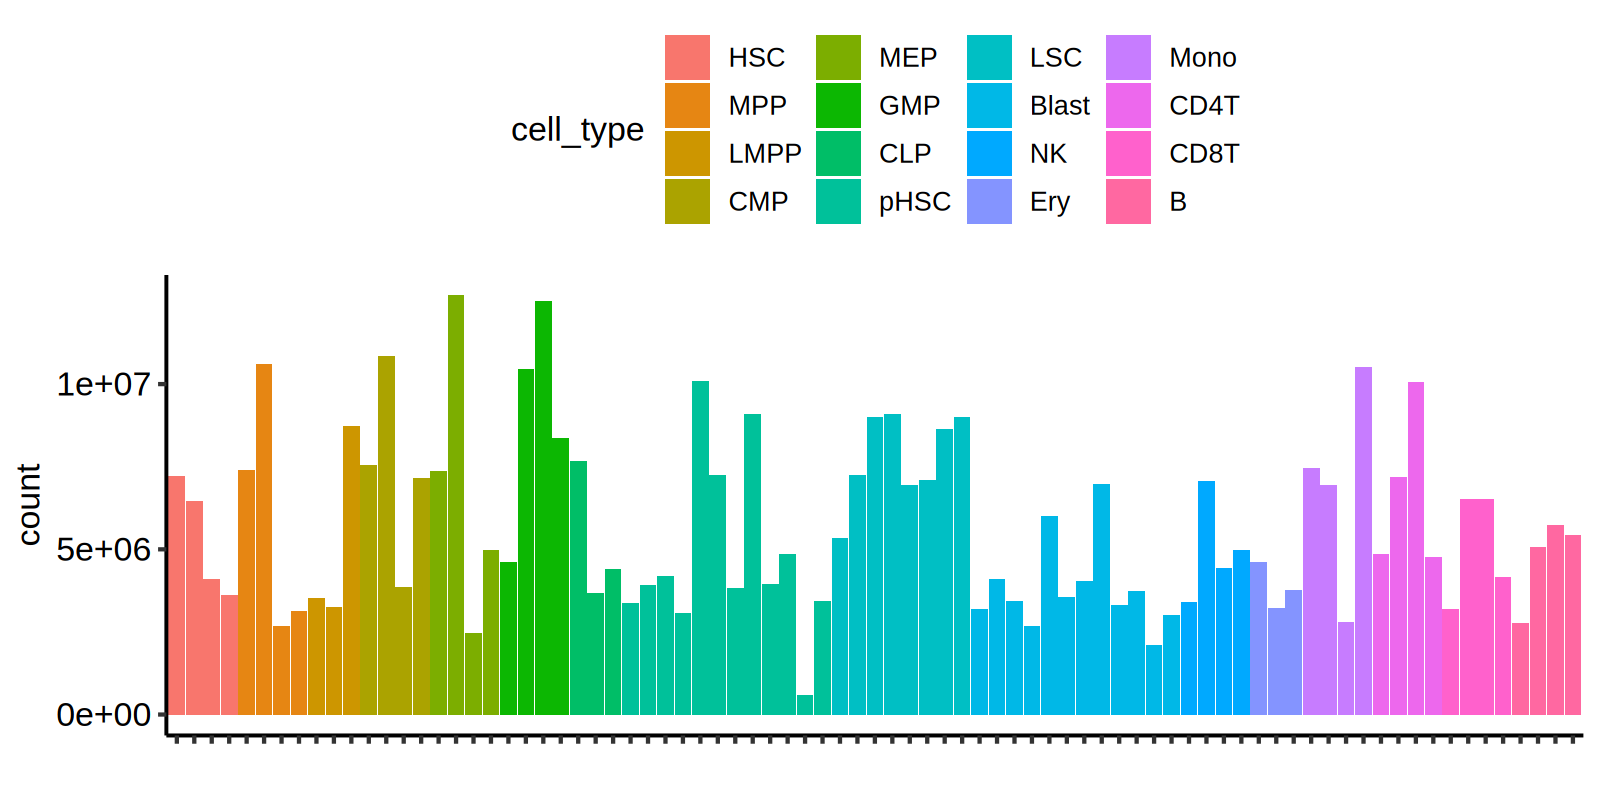

In [314]:
plotdat = apply(tecount_coding_mtx, 2, sum)
plotdat = as.data.table(plotdat, keep.rownames = T)
setnames(plotdat, c('sample_name', 'count'))
plotdat[, cell_type := sub('.*_', '', sample_name)]
plotdat[, cell_type := factor(cell_type, levels = cell_types)]
plotdat = plotdat[order(cell_type), ]
plotdat[, sample_name := factor(sample_name, levels = plotdat$sample_name)]

options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)
ggplot(plotdat, aes(sample_name, count, fill = cell_type)) + geom_bar(stat = 'identity') + theme_pubr() + theme(axis.text.x=element_blank()) + xlab('')


In [315]:
plotdat[which.min(plotdat$count), ]
plotdat[which.max(plotdat$count), ]

sample_name count  cell_type
1 SU583_pHSC  565150 pHSC

sample_name count    cell_type
1 D6792_MEP   12668340 MEP

In [316]:
plotdat[cell_type == 'pHSC', ]

sample_name count    cell_type
1  SU048_pHSC   3347846 pHSC     
2  SU070_pHSC   3911256 pHSC     
3  SU209_pHSC   4184837 pHSC     
4  SU351_pHSC   3054548 pHSC     
5  SU353_pHSC  10072196 pHSC     
6  SU444_pHSC   7242820 pHSC     
7  SU484_pHSC   3823873 pHSC     
8  SU496_pHSC   9091320 pHSC     
9  SU501_pHSC   3934549 pHSC     
10 SU575_pHSC   4834710 pHSC     
11 SU583_pHSC    565150 pHSC     
12 SU654_pHSC   3409914 pHSC

## PCA

In [317]:
row_sum = rowSums(tecount_coding_mtx[rownames(logcpm_coding),])
rsd  = rowSds(logcpm_coding)
summary(row_sum)
summary(rsd)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1385    3727   10065   31584   27626 7960159 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1598  0.5159  0.6930  0.7853  0.9684  3.2431 

In [318]:
dsn_sample$cell_type

[1] B     CD4T  CD8T  NK    B     CD4T  CD8T  CLP   Ery   NK    CLP   Ery   LMPP  NK    B     CD4T  CD8T  CMP   GMP   HSC   MEP   MPP   Mono  CMP   GMP   HSC   MEP   MPP   Mono  CLP  
[31] Ery   CMP   GMP   HSC   LMPP  MEP   MPP   Mono  B     CD4T  CD8T  CMP   GMP   HSC   LMPP  MEP   MPP   Mono  NK    Blast pHSC  Blast LSC   pHSC  Blast LSC   pHSC  Blast pHSC  Blast
[61] LSC   pHSC  Blast LSC   pHSC  Blast pHSC  Blast LSC   pHSC  Blast pHSC  Blast LSC   pHSC  Blast LSC   pHSC  Blast LSC   pHSC 
Levels: HSC MPP LMPP CMP MEP GMP CLP pHSC LSC Blast NK Ery Mono CD4T CD8T B

In [319]:
head(plotdat_x)

rn         PC1        PC2        PC3       PC4        PC5        PC6        PC7        PC8         PC9        ⋯ PC73        PC74        PC75        PC76       PC77         PC78       
1 D1022_B    -10.435874  0.5672634 -6.533954   2.335173 -3.8856183  1.4364203 -4.6822284  3.47982670 -8.9371192 ⋯  0.21899753 -0.02155713 -0.09304516 -0.1622734 -0.055470754 -0.06438797
2 D1022_CD4T -15.410320 -6.8584662 -8.879955  -4.528281 -2.4652766 -1.6508597 -2.7142710  0.01558896 -0.5346056 ⋯  0.06628046 -0.26000333 -0.31769739  0.4865443 -0.010350302  0.24005756
3 D1022_CD8T -19.050222 -7.6710085 -9.513522  -6.271738 -0.8857074 -4.4533752 -0.7072984 -1.13590960  2.1855836 ⋯  0.17950447  0.48362743  0.09311109  0.1889127  0.003073734  0.01725660
4 D1022_NK   -18.916291 -6.5780165 -8.377762  -5.297539 -0.1984271 -2.7690503  0.4068949 -5.16445301  0.7339633 ⋯ -0.19473561 -0.10903827 -0.06700782 -0.1064890 -0.510875088 -0.11324189
5 D2596_B     -9.158072 -2.5521767  4.521122  -7.854506 -2.3856212  8.8617995 -2.4776190  7.89783030 -1.2438498 ⋯ -0.02204034  0.07152134 -0.07153719  0.3180595 -0.145009966  0.01008612
6 D2596_CD4T -15.380953 -8.4212055  1.061146 -10.615250 -1.1209456  0.7106874  0.5791075  5.56913881  4.0280598 ⋯ -0.07606256 -0.23056364  0.35146634 -0.5134875  0.008120135 -0.23941192
  PC79        PC80         PC81         cell_type
1 -0.13283918  0.060432268 4.856686e-16 B        
2  0.12154219  0.082468011 1.770502e-16 CD4T     
3  0.01055343 -0.086817529 1.025299e-16 CD8T     
4 -0.05431895 -0.005402861 1.425898e-15 NK       
5 -0.11374110  0.034024178 2.588931e-16 B        
6  0.02592012 -0.098506132 2.247781e-15 CD4T

[1] 835  81

Warning message:
"ggrepel: 30 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


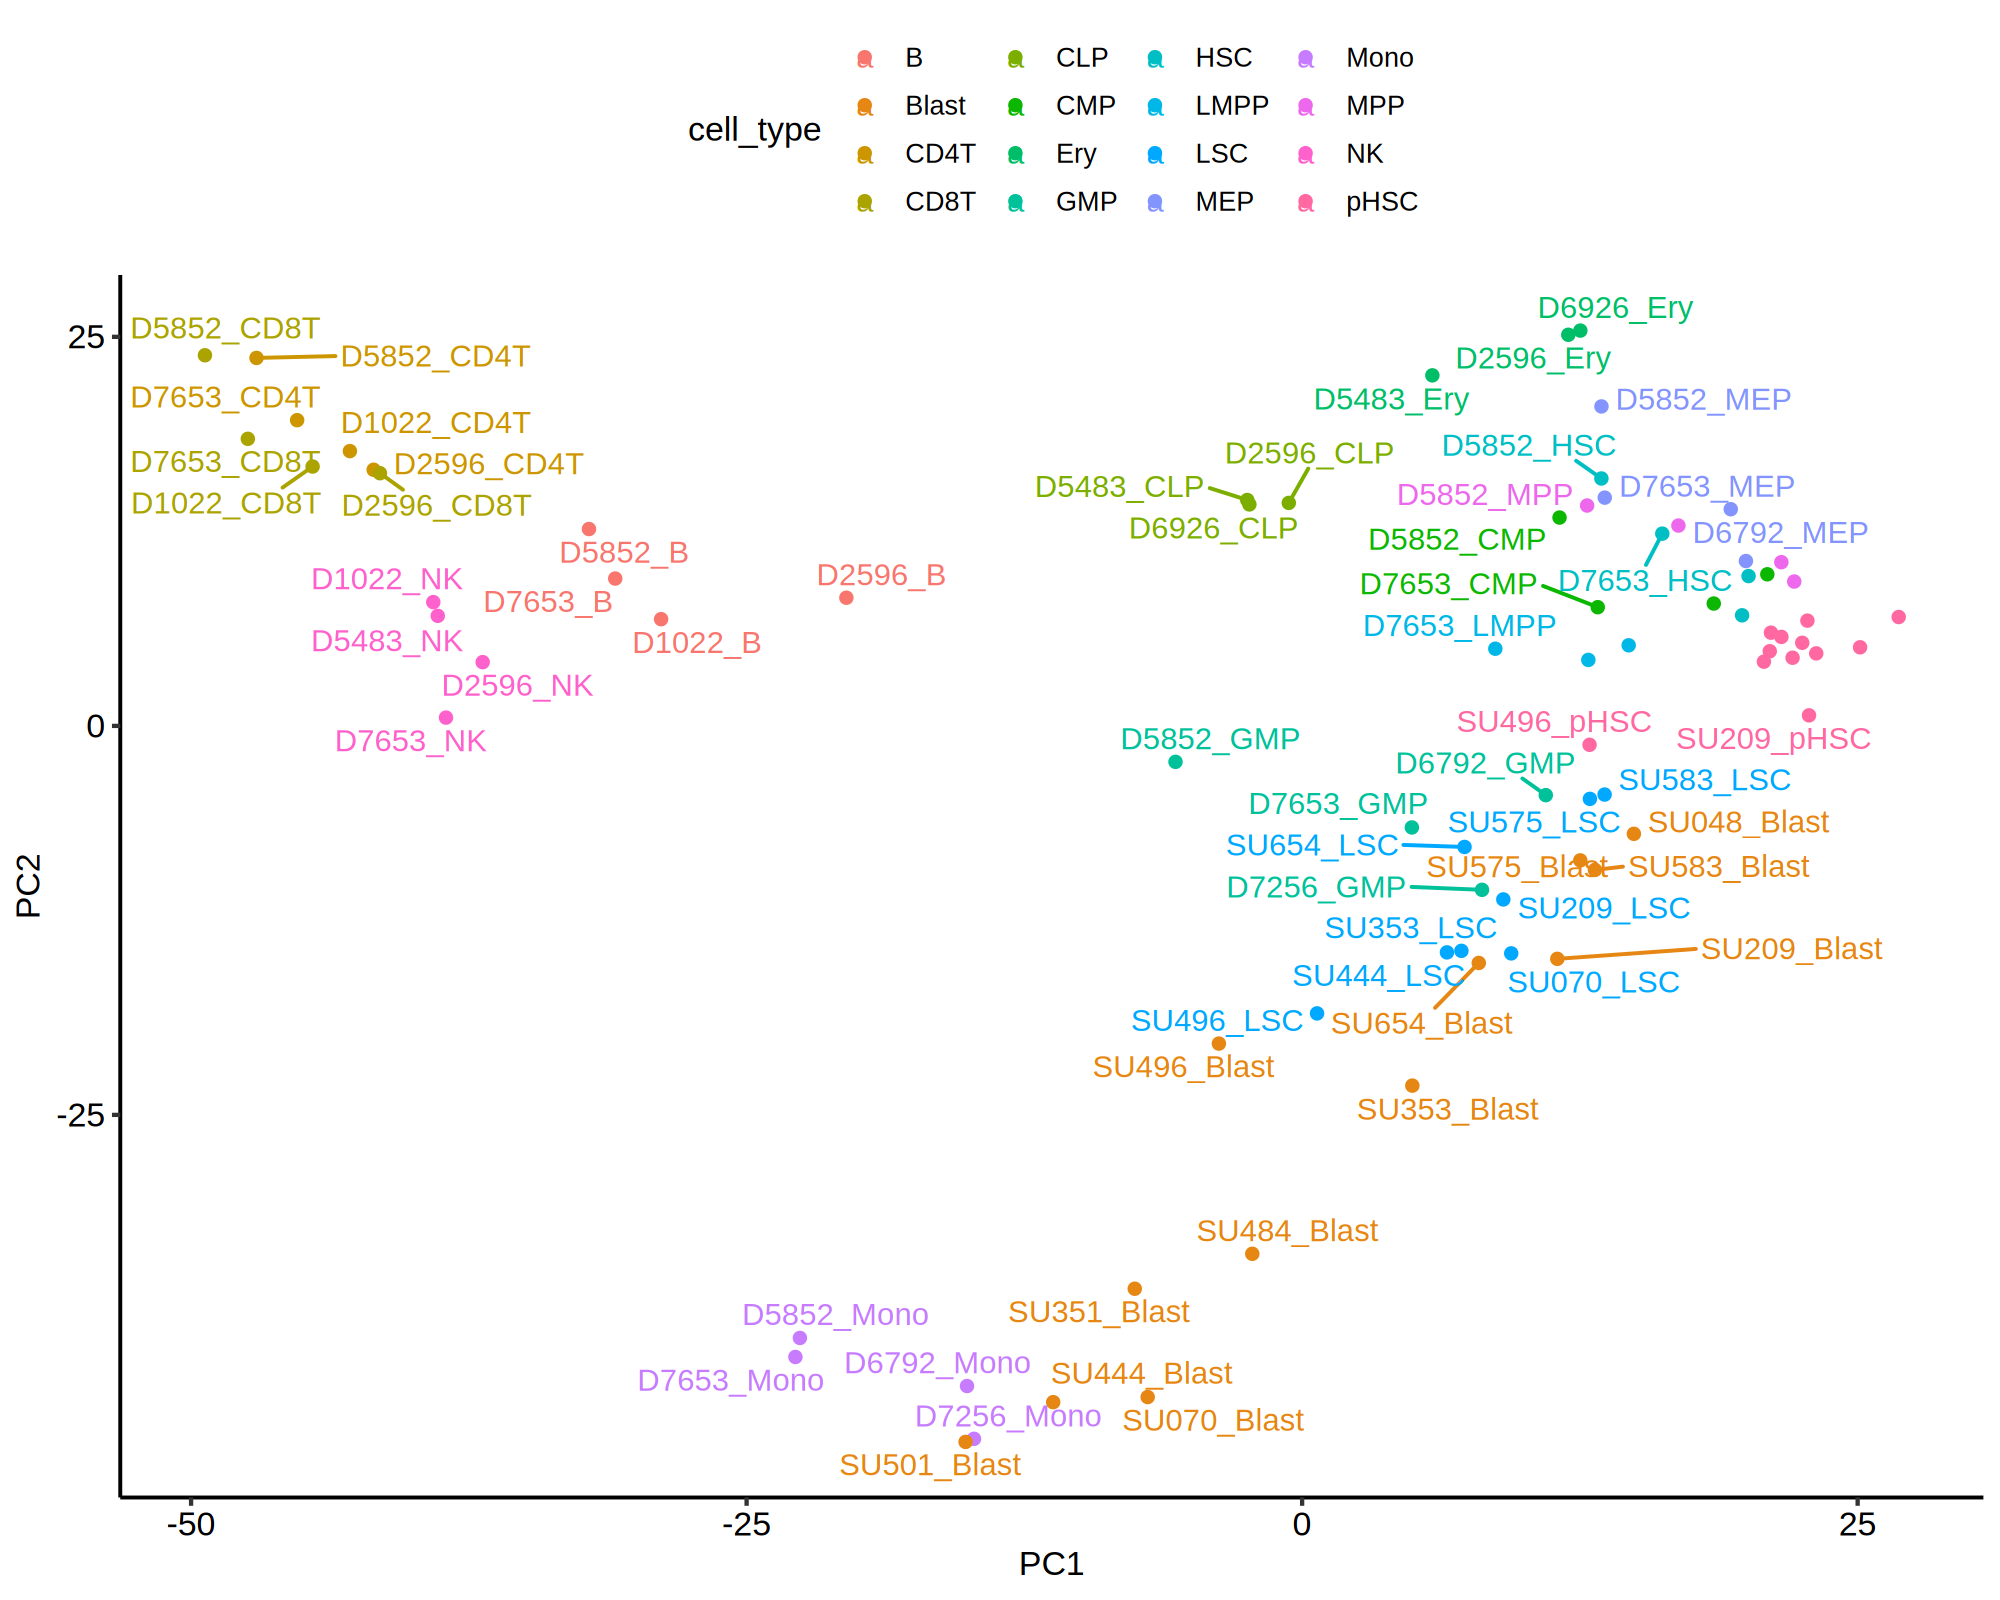

In [320]:
plotdat = logcpm_coding[rsd > 1 & row_sum > 22751, ]
dim(plotdat)

plotdat = scale(plotdat, scale = F, center = T)
plotdat = prcomp(t(plotdat))

plotdat_x = as.data.table(plotdat$x, keep.rownames = T)
plotdat_x[, cell_type := sub('.*_', '', rn)]

options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 200)
ggplot(plotdat_x, aes(PC1, PC2, label = rn, color = cell_type)) + geom_point() + theme_pubr() + geom_text_repel()


In [321]:
dim(tecount_coding_mtx)

[1] 57514    81

# heatmap for coding genes

In [322]:
dsn_sample$cell_type = factor(dsn_sample$cell_type, levels = cell_types)
           

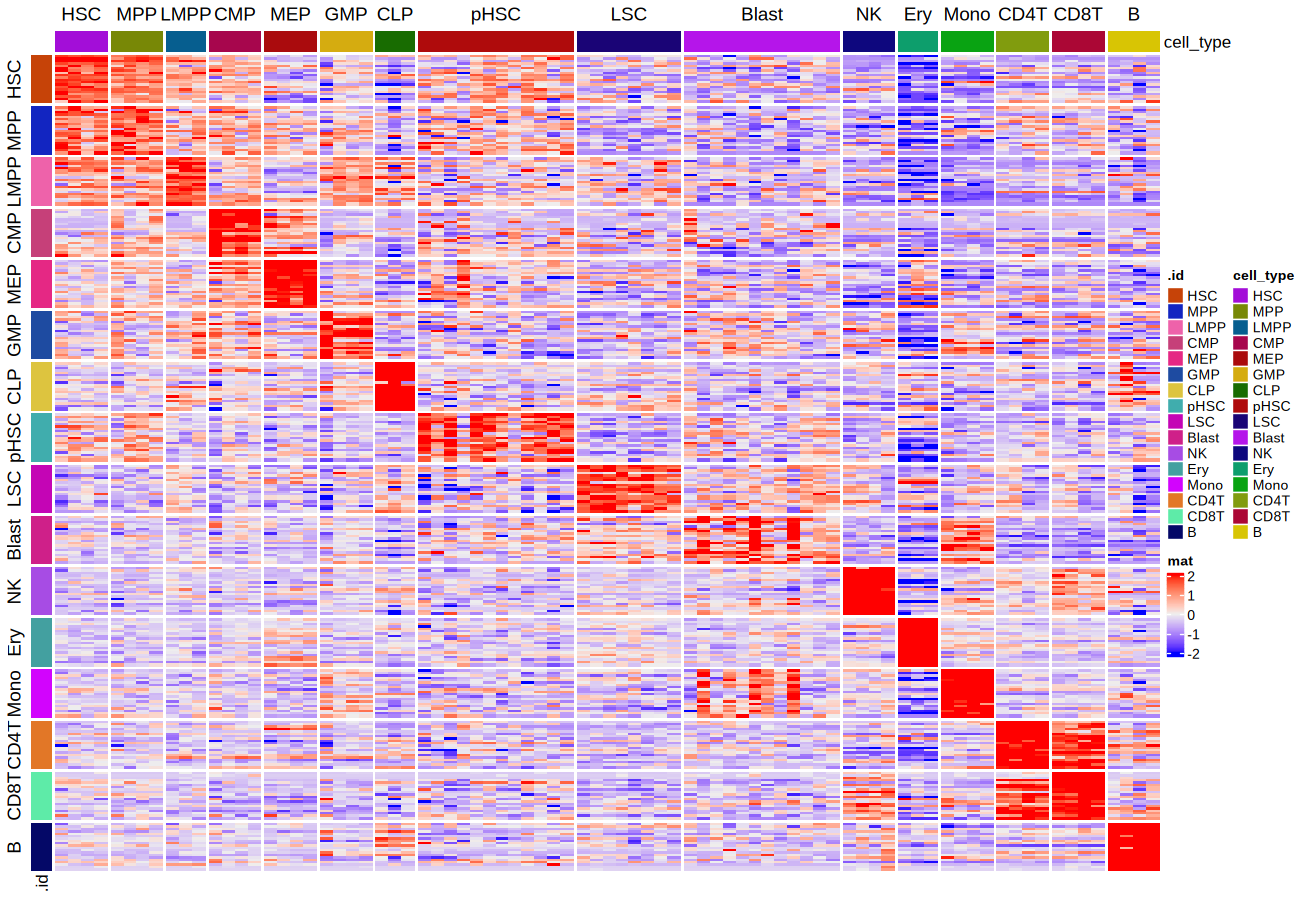

In [323]:
# top 20 up-regulated coding genes for each cell type
options(repr.plot.width = 13, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_coding_dt[logFC > 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
#ov = intersect(row_sel$rn, rownames(logcpm_coding))
#row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_coding[row_sel$rn, dsn_sample$sample_name]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_sample[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_sample$cell_type, levels = cell_types))  

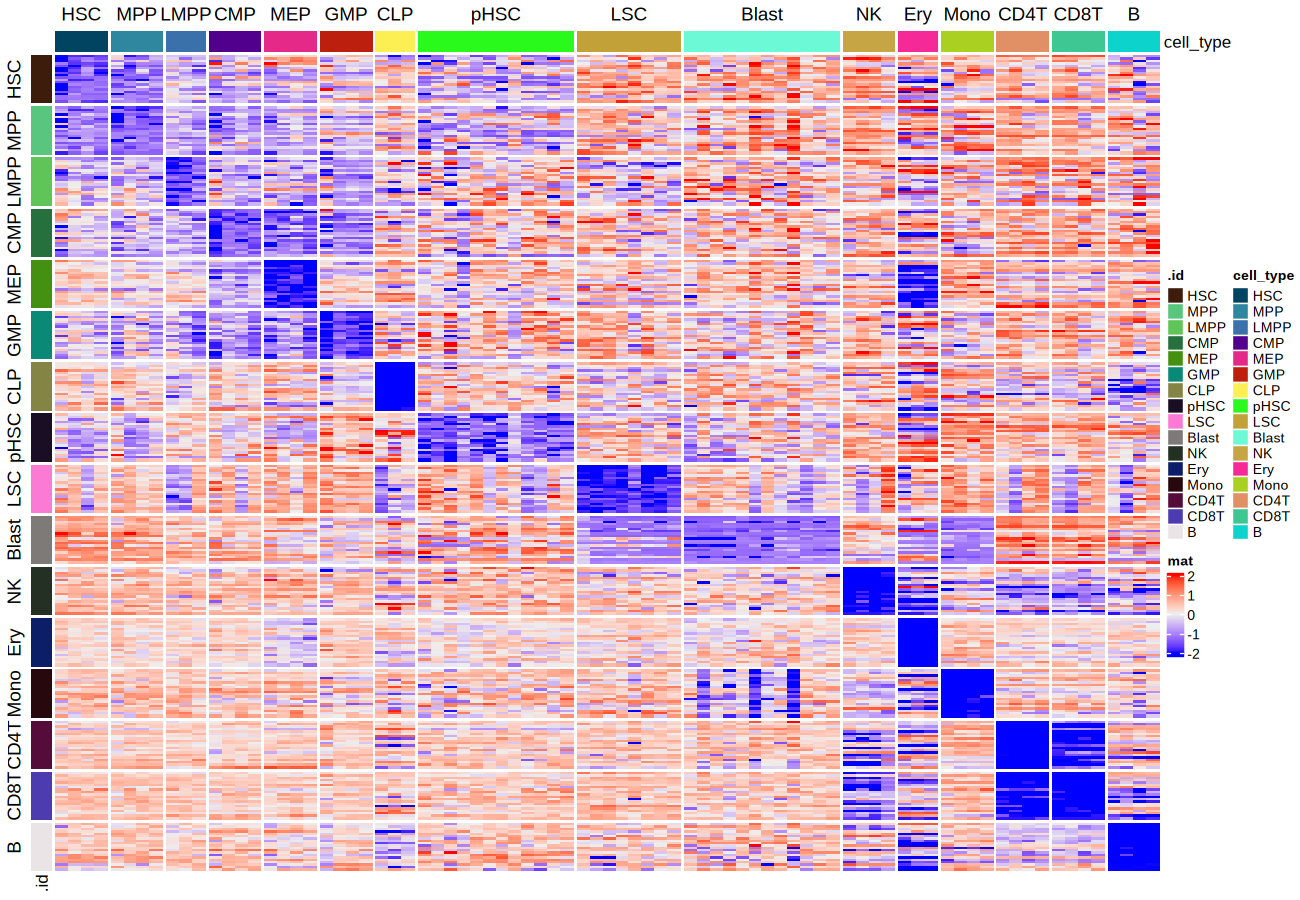

In [324]:
# top 20 up-regulated coding genes for each cell type
options(repr.plot.width = 13, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_coding_dt[logFC < 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
#ov = intersect(row_sel$rn, rownames(logcpm_coding))
#row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_coding[row_sel$rn, dsn_sample$sample_name]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_sample[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_sample$cell_type, levels = cell_types))  

# heatmap for TE genes

In [75]:
head(deg_te_dt) 

.id rn                     logFC      logCPM   PValue       FDR         
1 HSC MER30B:hAT-Charlie:DNA  0.9688782 5.555102 9.951595e-07 0.0009772467
2 HSC EuthAT-2:hAT-Ac:DNA    -0.5824408 7.941902 1.350535e-03 0.4130295103
3 HSC MER6:TcMar-Tigger:DNA   0.3602859 8.666368 2.086983e-03 0.4130295103
4 HSC LTR40a:ERVL:LTR         0.3987745 8.314667 2.233006e-03 0.4130295103
5 HSC EUTREP15:ERV1:LTR       1.0318172 4.547593 2.278216e-03 0.4130295103
6 HSC LTR33A_v:ERVL:LTR       0.5941878 8.064589 3.051101e-03 0.4130295103

[1] 245   7

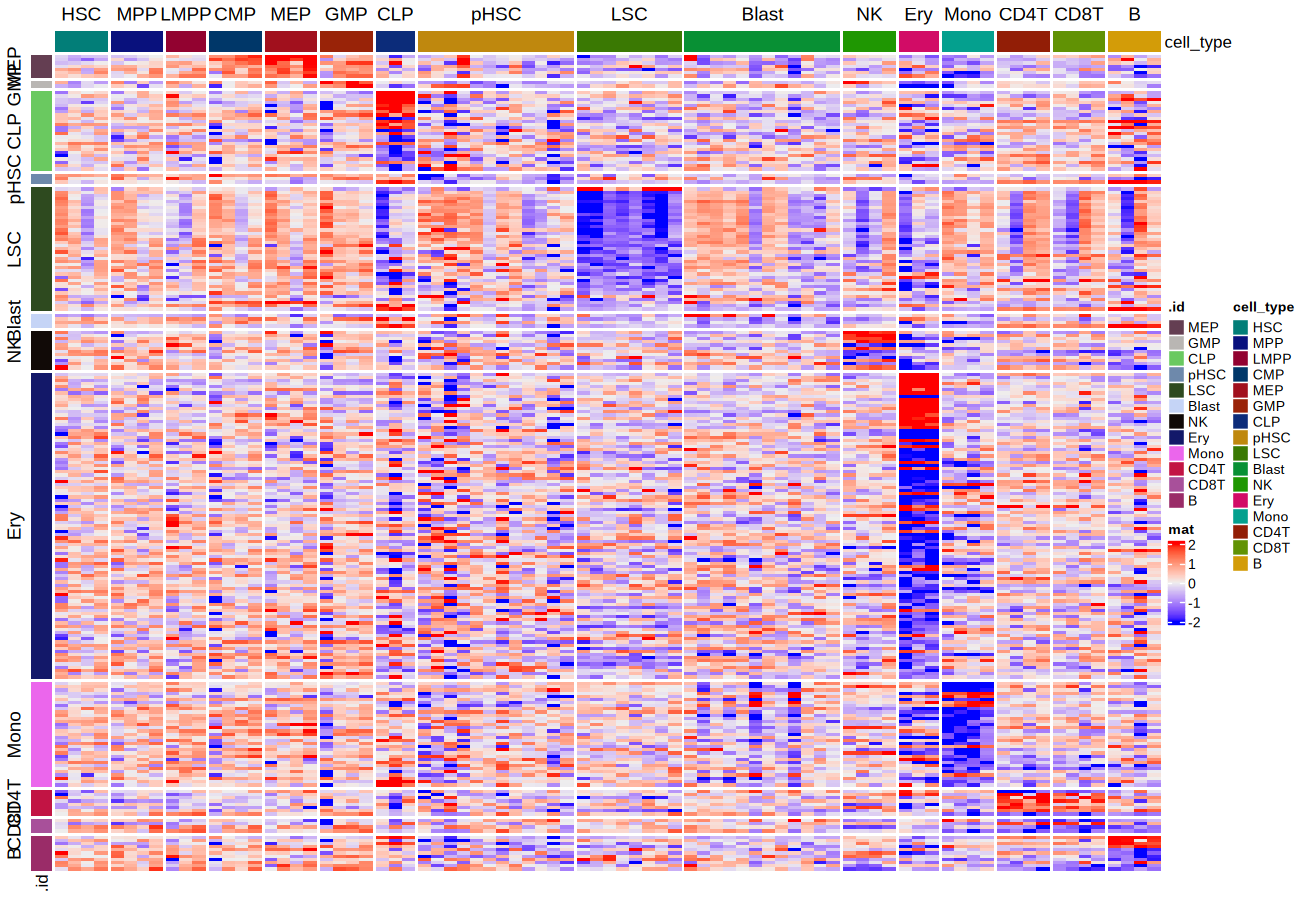

In [326]:
# significant TEs
options(repr.plot.width = 13, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_te_dt[abs(logFC) > 1 & FDR < 0.1, ]
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
dim(row_sel)

plotdat = logcpm_te[row_sel$rn, dsn_sample$sample_name]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_sample[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_sample$cell_type, levels = cell_types))  


## LSC vs Blast

SU048_Blast SU070_Blast SU070_LSC  SU209_Blast SU209_LSC   SU351_Blast SU353_Blast SU353_LSC   SU444_Blast SU444_LSC  SU484_Blast SU496_Blast SU496_LSC  SU501_Blast
HAL1M8:L1:LINE -0.26795788 -0.8627625  -1.2072420 -0.5157349  -0.41999041 -1.2234319  -0.1293020   1.97375001 -1.1738271   0.7146314 -1.17630127 -0.3593740  -0.5412200  0.1568040 
L1M2a:L1:LINE  -0.45098310 -0.8921375  -0.6680033 -0.7425663  -0.05487576 -1.6518803  -0.2377883  -0.20527536 -0.8940084   1.4234699  0.02680574  0.3711565   0.4205737 -1.0168789 
L1M2b:L1:LINE   0.32344278  0.4871654  -0.5530569  1.5613656  -0.60408699  0.6407125   0.8869627  -0.43698875 -1.8243324  -1.4004831  0.97829318  0.3830667  -1.4528972  0.6370580 
L1M3de:L1:LINE -0.08833884 -0.3075749   1.6375711  0.7909845  -0.28705847 -0.2299932   0.4535881   1.47329675 -2.0000000  -0.5565550 -1.03497321  0.2956771  -0.3556969 -0.8040030 
L1M3f:L1:LINE   0.87132063  1.0421875   0.7997220 -0.4517245  -0.01695811  2.0000000  -1.0261590   0.03816645  0.1754684   0.1998769 -1.64987084  0.4067878  -0.6852047 -0.1482895 
L1MA1:L1:LINE  -0.61883230 -1.3348491   1.5689586 -0.4417424   0.62056801 -1.1172680  -0.6309749   0.71296698 -1.1178537   1.0103742 -1.11633933 -1.1760647   0.9269303 -1.2903863 
               SU575_Blast SU575_LSC  SU583_Blast SU583_LSC  SU654_Blast SU654_LSC
HAL1M8:L1:LINE  0.6694440   0.9711721  0.8074866  -0.4632666  1.8809618   1.166161
L1M2a:L1:LINE   0.5172580   0.6076633 -0.5374716  -0.2433837  1.9225077   2.000000
L1M2b:L1:LINE   0.4882540  -0.6104554  1.0043616  -0.2213679  1.1871227  -1.474136
L1M3de:L1:LINE -0.2292568  -0.4154463  1.8093165   0.7397306  0.4966479  -1.059239
L1M3f:L1:LINE  -0.4884761   1.2060315 -1.0068789  -0.4394999 -0.8895438  -0.698659
L1MA1:L1:LINE   0.2246598   0.8657121  0.5770765   0.1392991  0.5300741   1.667691

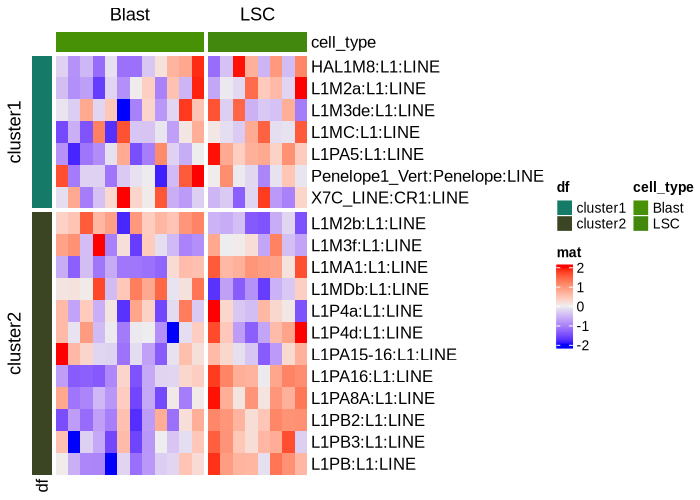

In [114]:
dsn_sel = dsn_sample[dsn_sample$cell_type %in% c('LSC', 'Blast'), ]
dsn_sel$cell_type = factor(dsn_sel$cell_type, levels = c('Blast', 'LSC'))

tmp = fread('~/collab_Farhan/cluster.tsv')
te_sel = tmp[gene %in% rownames(logcpm_te),]
te_sel[, cluster := paste0('cluster', cluster) ]

column_ra = rowAnnotation(df = te_sel[, cluster]) 

plotdat = logcpm_te[te_sel$gene, dsn_sel$sample_name]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2
head(plotdat)
 
column_ha = HeatmapAnnotation(df = dsn_sel[, 'cell_type', drop = F])

options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 100)
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F, show_row_dend = F, top_annotation = column_ha, column_split = factor(dsn_sel$cell_type), 
        left_annotation = column_ra, row_split = te_sel$cluster)


SU048_Blast SU070_Blast SU070_LSC  SU209_Blast SU209_LSC    SU351_Blast SU353_Blast SU353_LSC  SU444_Blast SU444_LSC  SU484_Blast SU496_Blast SU496_LSC 
(GAATG)n:Satellite:Satellite -0.5270744  -1.457979    0.9061251 -1.299079   -0.005769106 -1.8267227  -0.1851104   0.4897650  0.5349369   1.5416572 -1.0908955  -1.1408120   1.1400689
AluY:Alu:SINE                 1.0504984   1.395801   -1.2864240  1.229088   -1.287830697  1.0048657   1.3783582  -0.6677874 -0.4085804  -0.8487275  1.1987055   0.9756370  -0.5634519
AluYa5:Alu:SINE               0.9533834   1.195138   -1.3516536  1.244785   -1.063152610  0.7602096   1.6713577  -0.5634742 -0.5299787  -1.0262874  1.2334195   0.7964596  -0.5889029
AluYb8:Alu:SINE               1.1358378   1.513522   -1.0769465  1.273919   -1.054491235  1.1950275   1.3610560  -0.9173907 -0.3480692  -1.0136200  0.8620904   0.6767172  -0.5067902
AluYc:Alu:SINE                0.9927463   1.223933   -0.9103354  1.376726   -1.076317696  0.8708020   1.4032812  -0.7740362 -0.4492340  -1.1826229  0.9243311   1.0824966  -0.5708802
AluYf1:Alu:SINE               1.1498347   1.007175   -1.1782002  1.265332   -1.313876672  0.9569890   1.5312220  -0.7235764 -0.3500425  -0.6082633  1.0929748   0.9459308  -0.1414501
                             SU501_Blast SU575_Blast SU575_LSC  SU583_Blast SU583_LSC  SU654_Blast SU654_LSC 
(GAATG)n:Satellite:Satellite  0.09216793  0.9523415   1.1594231  0.34145862 -0.8687735 0.3798209    0.8644503
AluY:Alu:SINE                -0.38276003 -0.2056985  -1.0330657 -0.26417578 -1.5135068 0.6304200   -0.4013652
AluYa5:Alu:SINE              -0.34715575 -0.3066997  -0.7441769 -0.15747779 -1.4119874 1.0709060   -0.8347125
AluYb8:Alu:SINE              -0.53251864 -0.4460031  -1.1128466 -0.06193744 -1.5435077 0.8034484   -0.2074968
AluYc:Alu:SINE               -0.35981473 -0.2525973  -1.3736855  0.17896733 -1.3597402 0.9528550   -0.6968743
AluYf1:Alu:SINE              -0.22275591 -0.2275946  -1.5382073 -0.72240028 -1.3863135 0.7529263   -0.2897032

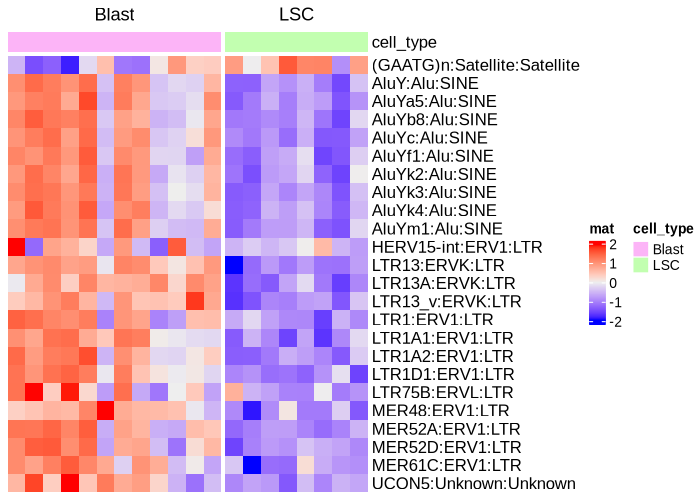

In [95]:
dsn_sel = dsn_sample[dsn_sample$cell_type %in% c('LSC', 'Blast'), ]
dsn_sel$cell_type = factor(dsn_sel$cell_type, levels = c('Blast', 'LSC'))

te_sel = deg_lsc_blast[abs(logFC) > 1 & FDR < 0.05, rn]
te_sel = intersect(rownames(logcpm_te), te_sel)

plotdat = logcpm_te[te_sel, dsn_sel$sample_name]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2
head(plotdat)
 
column_ha = HeatmapAnnotation(df = dsn_sel[, 'cell_type', drop = F])

options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 100)
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F, show_row_dend = F, top_annotation = column_ha, column_split = factor(dsn_sel$cell_type))  



In [99]:
te_sel = c('(GAATG)n:Satellite:Satellite', 'AluY:Alu:SINE', 'AluYa5:Alu:SINE', 'AluYb8:Alu:SINE', 'AluYc:Alu:SINE', 'AluYf1:Alu:SINE', 'AluYk2:Alu:SINE', 
'AluYk3:Alu:SINE', 'AluYk4:Alu:SINE', 'AluYm1:Alu:SINE', 'HERV15-int:ERV1:LTR', 'LTR13:ERVK:LTR', 'LTR13A:ERVK:LTR', 'LTR13_v:ERVK:LTR', 'LTR1:ERV1:LTR', 
'LTR1A1:ERV1:LTR', 'LTR1A2:ERV1:LTR', 'LTR1D1:ERV1:LTR', 'LTR75B:ERVL:LTR', 'MER48:ERV1:LTR', 'MER52A:ERV1:LTR', 'MER52D:ERV1:LTR', 'MER61C:ERV1:LTR', 'UCON5:Unknown:Unknown') 


## HSC LINE in mature cell and blast 

[1] 23  3

[1] 19  3

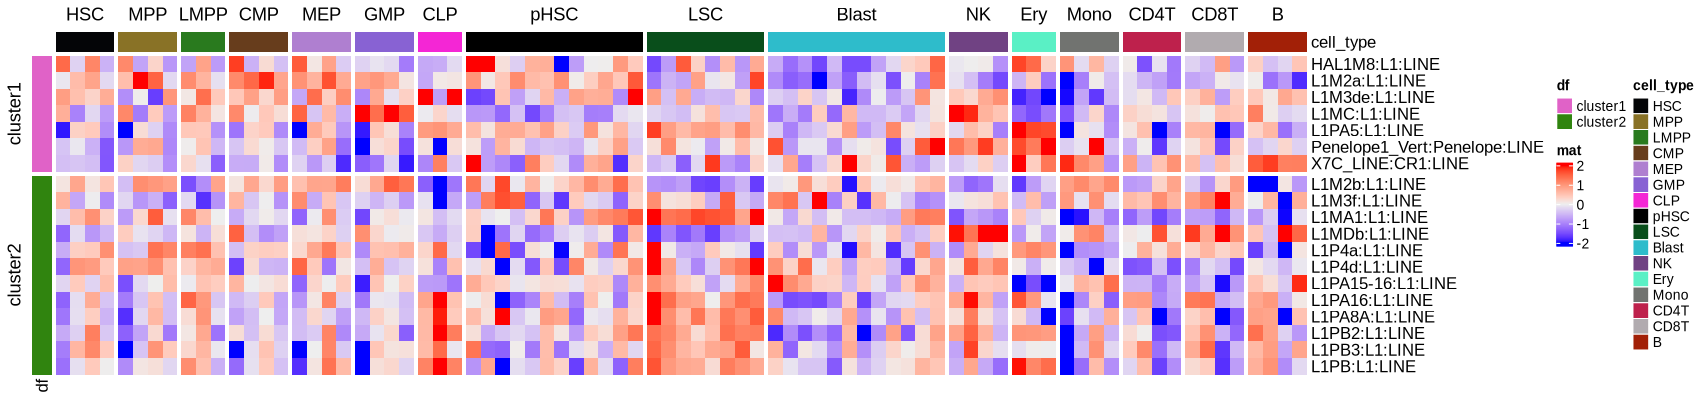

In [7]:
cluster_info = fread('~/WenhuoHu/collab_Farhan/cluster.tsv')
cluster_info[, cluster := paste0('cluster', cluster) ]
cluster_info[, gene_cluster := paste0(gene, '_', cluster) ]
dim(cluster_info)
cluster_info = cluster_info[gene %in% rownames(logcpm_te) , ]
dim(cluster_info)
plotdat = logcpm_te[cluster_info$gene, dsn_sample$sample_name]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2
 
column_ha = HeatmapAnnotation(df = dsn_sample[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = cluster_info[, cluster]) 

options(repr.plot.width = 17, repr.plot.height = 4, repr.plot.res = 100)
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = cluster_info[, cluster], 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_sample$cell_type))  


In [18]:
gmt = list(hsc_dn = cluster_info[cluster == 'cluster1', gene] ,  hsc_up = cluster_info[cluster == 'cluster2', gene] ) 

In [8]:
library(GSVA)

In [41]:
ls()

[1] "add_ann"                  "adjusted"                 "aml_fuse"                 "aml_genes"                "aml_mut"                  "base_dir"                
  [7] "batch"                    "bin_tecount"              "bin_telocal"              "cell_types"               "cell_types_hspc"          "cluster_info"            
 [13] "coding_genes"             "col_sum"                  "column_ha"                "column_ra"                "combn_fun"                "count_matrix"            
 [19] "cpm_fun"                  "create_named_list"        "cut_quantile"             "data_dir"                 "deg_coding_dt"            "deg_coding_list"         
 [25] "deg_fun"                  "deg_fun2"                 "deg_local_fun"            "deg_te_dt"                "deg_te_dt_hspc"           "deg_te_list"             
 [31] "deg_telocal_fun"          "design"                   "dge_coding"               "dge_te"                   "dsn"                      "dsn_bp"                  
 [37] "dsn_df"                   "dsn_merged"               "dsn_sample"               "dsn_sample_dt"            "dsn_sample_hscp"          "dsn_sample_hspc"         
 [43] "exe_telocal"              "fgsea_fun"                "fit_all"                  "fname"                    "genome_fun"               "gg"                      
 [49] "gmt"                      "graph_dt"                 "GTF_FILE"                 "head2"                    "heatmap_fun"              "logcpm_all"              
 [55] "logcpm_coding"            "logcpm_fun"               "logcpm_te"                "logcpm_te_hspc"           "mtx_ranged"               "ov"                      
 [61] "path"                     "pathway_fun"              "pca_fun"                  "plotdat"                  "plotdat_2"                "plotdat_x"               
 [67] "plotdat0"                 "plotdat1"                 "plotdat2"                 "PP"                       "ranking_fun"              "REFERENCE_GENOME"        
 [73] "row_sel"                  "row_sel_geneID"           "row_sum"                  "rsd"                      "rsum"                     "run_dir"                 
 [79] "scale_fun"                "share_dir"                "sif"                      "sif_telocal"              "size"                     "size_fun"                
 [85] "species"                  "subtype"                  "surv_fun"                 "surv_sum_fun"             "tail2"                    "te_dt"                   
 [91] "te_genes"                 "TE_GTF_FILE"              "TE_loc_GTF_FILE"          "tecount_coding_mtx"       "tecount_coding_mtx_2"     "tecount_coding_mtx_batch"
 [97] "tecount_dt"               "tecount_list"             "tecount_mtx"              "tecount_mtx_batch"        "tecount_te_mtx"           "tmp"                     
[103] "tmp1"                     "tmp2"                     "tmp3"                     "tmp4"                     "txdb"

In [39]:
plotdat = scale_fun(logcpm_te)
plotdat = gsva(plotdat, gmt)
plotdat = as.data.table(t(plotdat), keep.rownames = T) 
plotdat = merge(plotdat, dsn_sample, by.x = 'rn', by.y = 'sample_name') 

Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”


Estimating GSVA scores for 2 gene sets.
Estimating ECDFs with Gaussian kernels
  |==================================================================================================================================================================================| 100%



In [19]:
plotdat = gsva(as.matrix(logcpm_te), gmt)
plotdat = as.data.table(t(plotdat), keep.rownames = T) 
plotdat = merge(plotdat, dsn_sample, by.x = 'rn', by.y = 'sample_name') 


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”


Estimating GSVA scores for 2 gene sets.
Estimating ECDFs with Gaussian kernels
  |==================================================================================================================================================================================| 100%



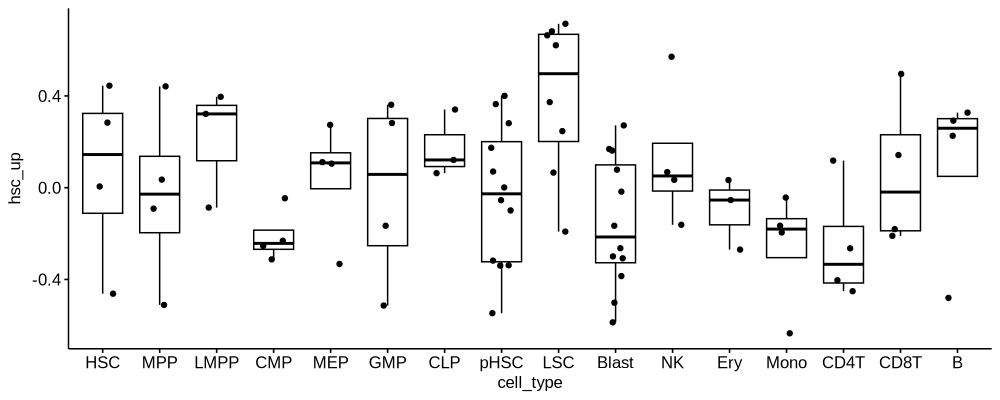

In [40]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 100)
gg = ggboxplot(plotdat, x = 'cell_type', y = 'hsc_up', add = "jitter")
gg
fname = '~/WenhuoHu/collab_Farhan/plot/hsc_up_lsc.pdf'
ggsave(gg, file = fname, width = 10, height = 4)

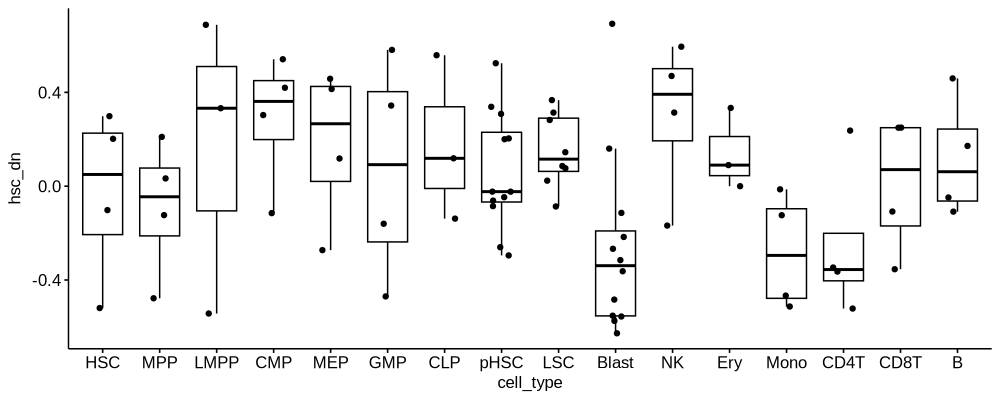

In [35]:
gg = ggboxplot(plotdat, x = 'cell_type', y = 'hsc_dn', add = 'jitter')
gg
fname = '~/WenhuoHu/collab_Farhan/plot/hsc_dn_lsc.pdf'
ggsave(gg, file = fname, width = 10, height = 4)

In [ ]:
c('L1MA1:L1:LINE',  'L1PA16:L1:LINE', 'L1PA8A:L1:LINE', 'L1PB2:L1:LINE', 'L1PB3:L1:LINE', 'L1PB:L1:LINE') 
# 'L1MDb:L1:LINE', 'L1P4a:L1:LINE', 'L1P4d:L1:LINE', 'L1M3f:L1:LINE', 'L1PA15-16:L1:LINE', 

In [38]:
cluster_info$gene

[1] "L1M3f:L1:LINE"     "L1MA1:L1:LINE"     "L1MDb:L1:LINE"     "L1P4a:L1:LINE"     "L1P4d:L1:LINE"     "L1PA15-16:L1:LINE" "L1PA16:L1:LINE"    "L1PA8A:L1:LINE"    "L1PB2:L1:LINE"    
[10] "L1PB3:L1:LINE"     "L1PB:L1:LINE"

In [39]:
cluster_info

gene              cluster  gene_cluster              
1  L1M3f:L1:LINE     cluster1 L1M3f:L1:LINE_cluster1    
2  L1MA1:L1:LINE     cluster1 L1MA1:L1:LINE_cluster1    
3  L1MDb:L1:LINE     cluster1 L1MDb:L1:LINE_cluster1    
4  L1P4a:L1:LINE     cluster1 L1P4a:L1:LINE_cluster1    
5  L1P4d:L1:LINE     cluster1 L1P4d:L1:LINE_cluster1    
6  L1PA15-16:L1:LINE cluster1 L1PA15-16:L1:LINE_cluster1
7  L1PA16:L1:LINE    cluster1 L1PA16:L1:LINE_cluster1   
8  L1PA8A:L1:LINE    cluster1 L1PA8A:L1:LINE_cluster1   
9  L1PB2:L1:LINE     cluster1 L1PB2:L1:LINE_cluster1    
10 L1PB3:L1:LINE     cluster1 L1PB3:L1:LINE_cluster1    
11 L1PB:L1:LINE      cluster1 L1PB:L1:LINE_cluster1

In [ ]:
# significant TEs
options(repr.plot.width = 13, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_te_dt[abs(logFC) > 1 & FDR < 0.1, ]
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
dim(row_sel)

plotdat = logcpm_te[row_sel$rn, dsn_sample$sample_name]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_sample[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_sample$cell_type, levels = cell_types))  


In [16]:
head(logcpm_te)

D1022_B   D1022_CD4T D1022_CD8T D1022_NK  D2596_B   D2596_CD4T D2596_CD8T D2596_CLP D2596_Ery D2596_NK  ⋯ SU501_pHSC SU575_Blast SU575_LSC SU575_pHSC
(GAATG)n:Satellite:Satellite  4.735376  4.243390   4.122256   4.794935  4.350590  3.469448   3.690973   3.432719  5.015227  3.797294 ⋯  2.019446   4.352372    4.557967  3.542369 
ALR/Alpha:centr:Satellite     4.860747  4.589341   4.479855   4.323883  4.730196  4.547085   4.359070   4.794491  4.140939  4.165597 ⋯  5.520925   5.563756    5.559317  5.061351 
Alu:Alu:SINE                  6.084528  5.904827   5.942804   6.030917  5.896804  5.871372   5.783757   5.686451  6.066056  5.779606 ⋯  5.804186   5.791566    5.761878  5.793317 
AluJb:Alu:SINE               11.286628 11.251866  11.122766  11.286474 10.842427 10.904556  10.891790  10.810017 11.051181 10.967586 ⋯ 10.947834  10.997856   10.755339 11.063074 
AluJo:Alu:SINE                8.149792  8.107794   8.060379   8.229884  7.873321  7.856105   7.843773   7.771410  8.032796  7.986803 ⋯  7.898754   8.008044    7.814751  8.012171 
AluJr4:Alu:SINE               7.647677  7.706141   7.604194   7.731507  7.319052  7.448429   7.429694   7.246976  7.469077  7.493831 ⋯  7.425699   7.443588    7.312070  7.527369 
                             SU583_Blast SU583_LSC SU583_pHSC SU654_Blast SU654_LSC SU654_pHSC
(GAATG)n:Satellite:Satellite  3.745875    2.544332  3.762840   3.783962    4.265112  2.329564 
ALR/Alpha:centr:Satellite     5.967962    5.044173  5.619898   5.399627    5.393633  5.414051 
Alu:Alu:SINE                  5.712869    5.526031  6.102443   5.890851    5.934093  6.104969 
AluJb:Alu:SINE               10.644037   10.612790 10.981544  10.998212   11.083879 11.046698 
AluJo:Alu:SINE                7.645061    7.607049  7.896518   7.954990    8.022914  7.941593 
AluJr4:Alu:SINE               7.124689    7.127266  7.525592   7.418295    7.634904  7.395560

# compared with blueprint results 

In [37]:
deg_te_bp_dt =  fread('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/deg_te.xls') 


In [38]:
head(deg_te_bp_dt)

.id rn                      logFC      logCPM    PValue      FDR      
1 HSC FLAM_C:Alu:SINE         -0.9128241 12.467095 0.003354908 0.5944787
2 HSC UCON44:TcMar-Tigger:DNA -1.6884823  7.812925 0.004110851 0.5944787
3 HSC L1ME3G:L1:LINE          -0.5030516 12.483404 0.005752892 0.5944787
4 HSC L1ME4a:L1:LINE          -0.5586001 12.695243 0.007049395 0.5944787
5 HSC MER33:hAT-Charlie:DNA   -0.7200624 10.986634 0.008228203 0.5944787
6 HSC ERVL-B4-int:ERVL:LTR     0.6461831  8.966138 0.009950680 0.5944787

In [42]:
bp_cmp = deg_te_bp_dt[.id == 'CMP' & logFC < -1 & FDR < 0.1, rn]
gse_lsc = deg_te_dt[.id == 'LSC' & logFC < -1 & FDR < 0.1, rn]
intersect(bp_cmp, gse_lsc)


[1] "LTR1E:ERV1:LTR"

# tree plot

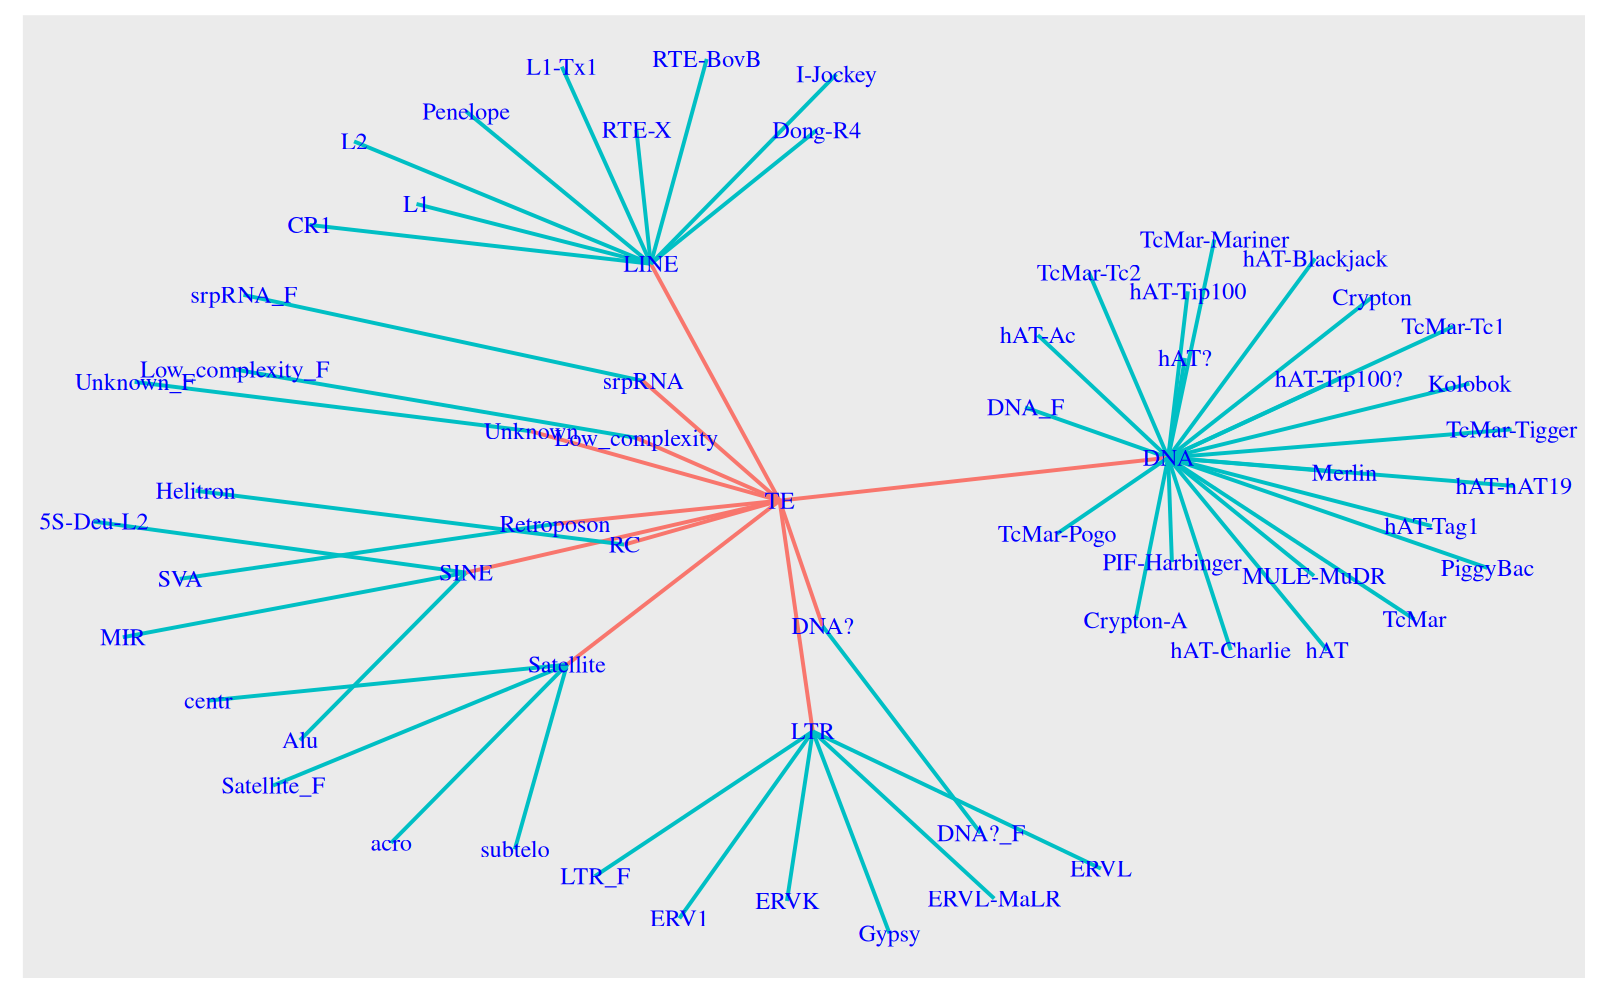

In [177]:
# from nb_TE_blueprint_HSPC_2024May29.ipynb
graph_dt = fread(file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/graph_dt')
plotdat = graph_dt[lvl %in% c('lvl1', 'lvl2'), ]  
plotdat = as_tbl_graph(plotdat)

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)
ggraph(plotdat, layout = 'stress') +  geom_edge_link(aes(colour = factor(lvl))) +  #geom_node_point() + 
  geom_node_text(aes(label = name),  colour = 'blue', size=3, show.legend = FALSE, family = "serif") + theme(legend.position = "none")


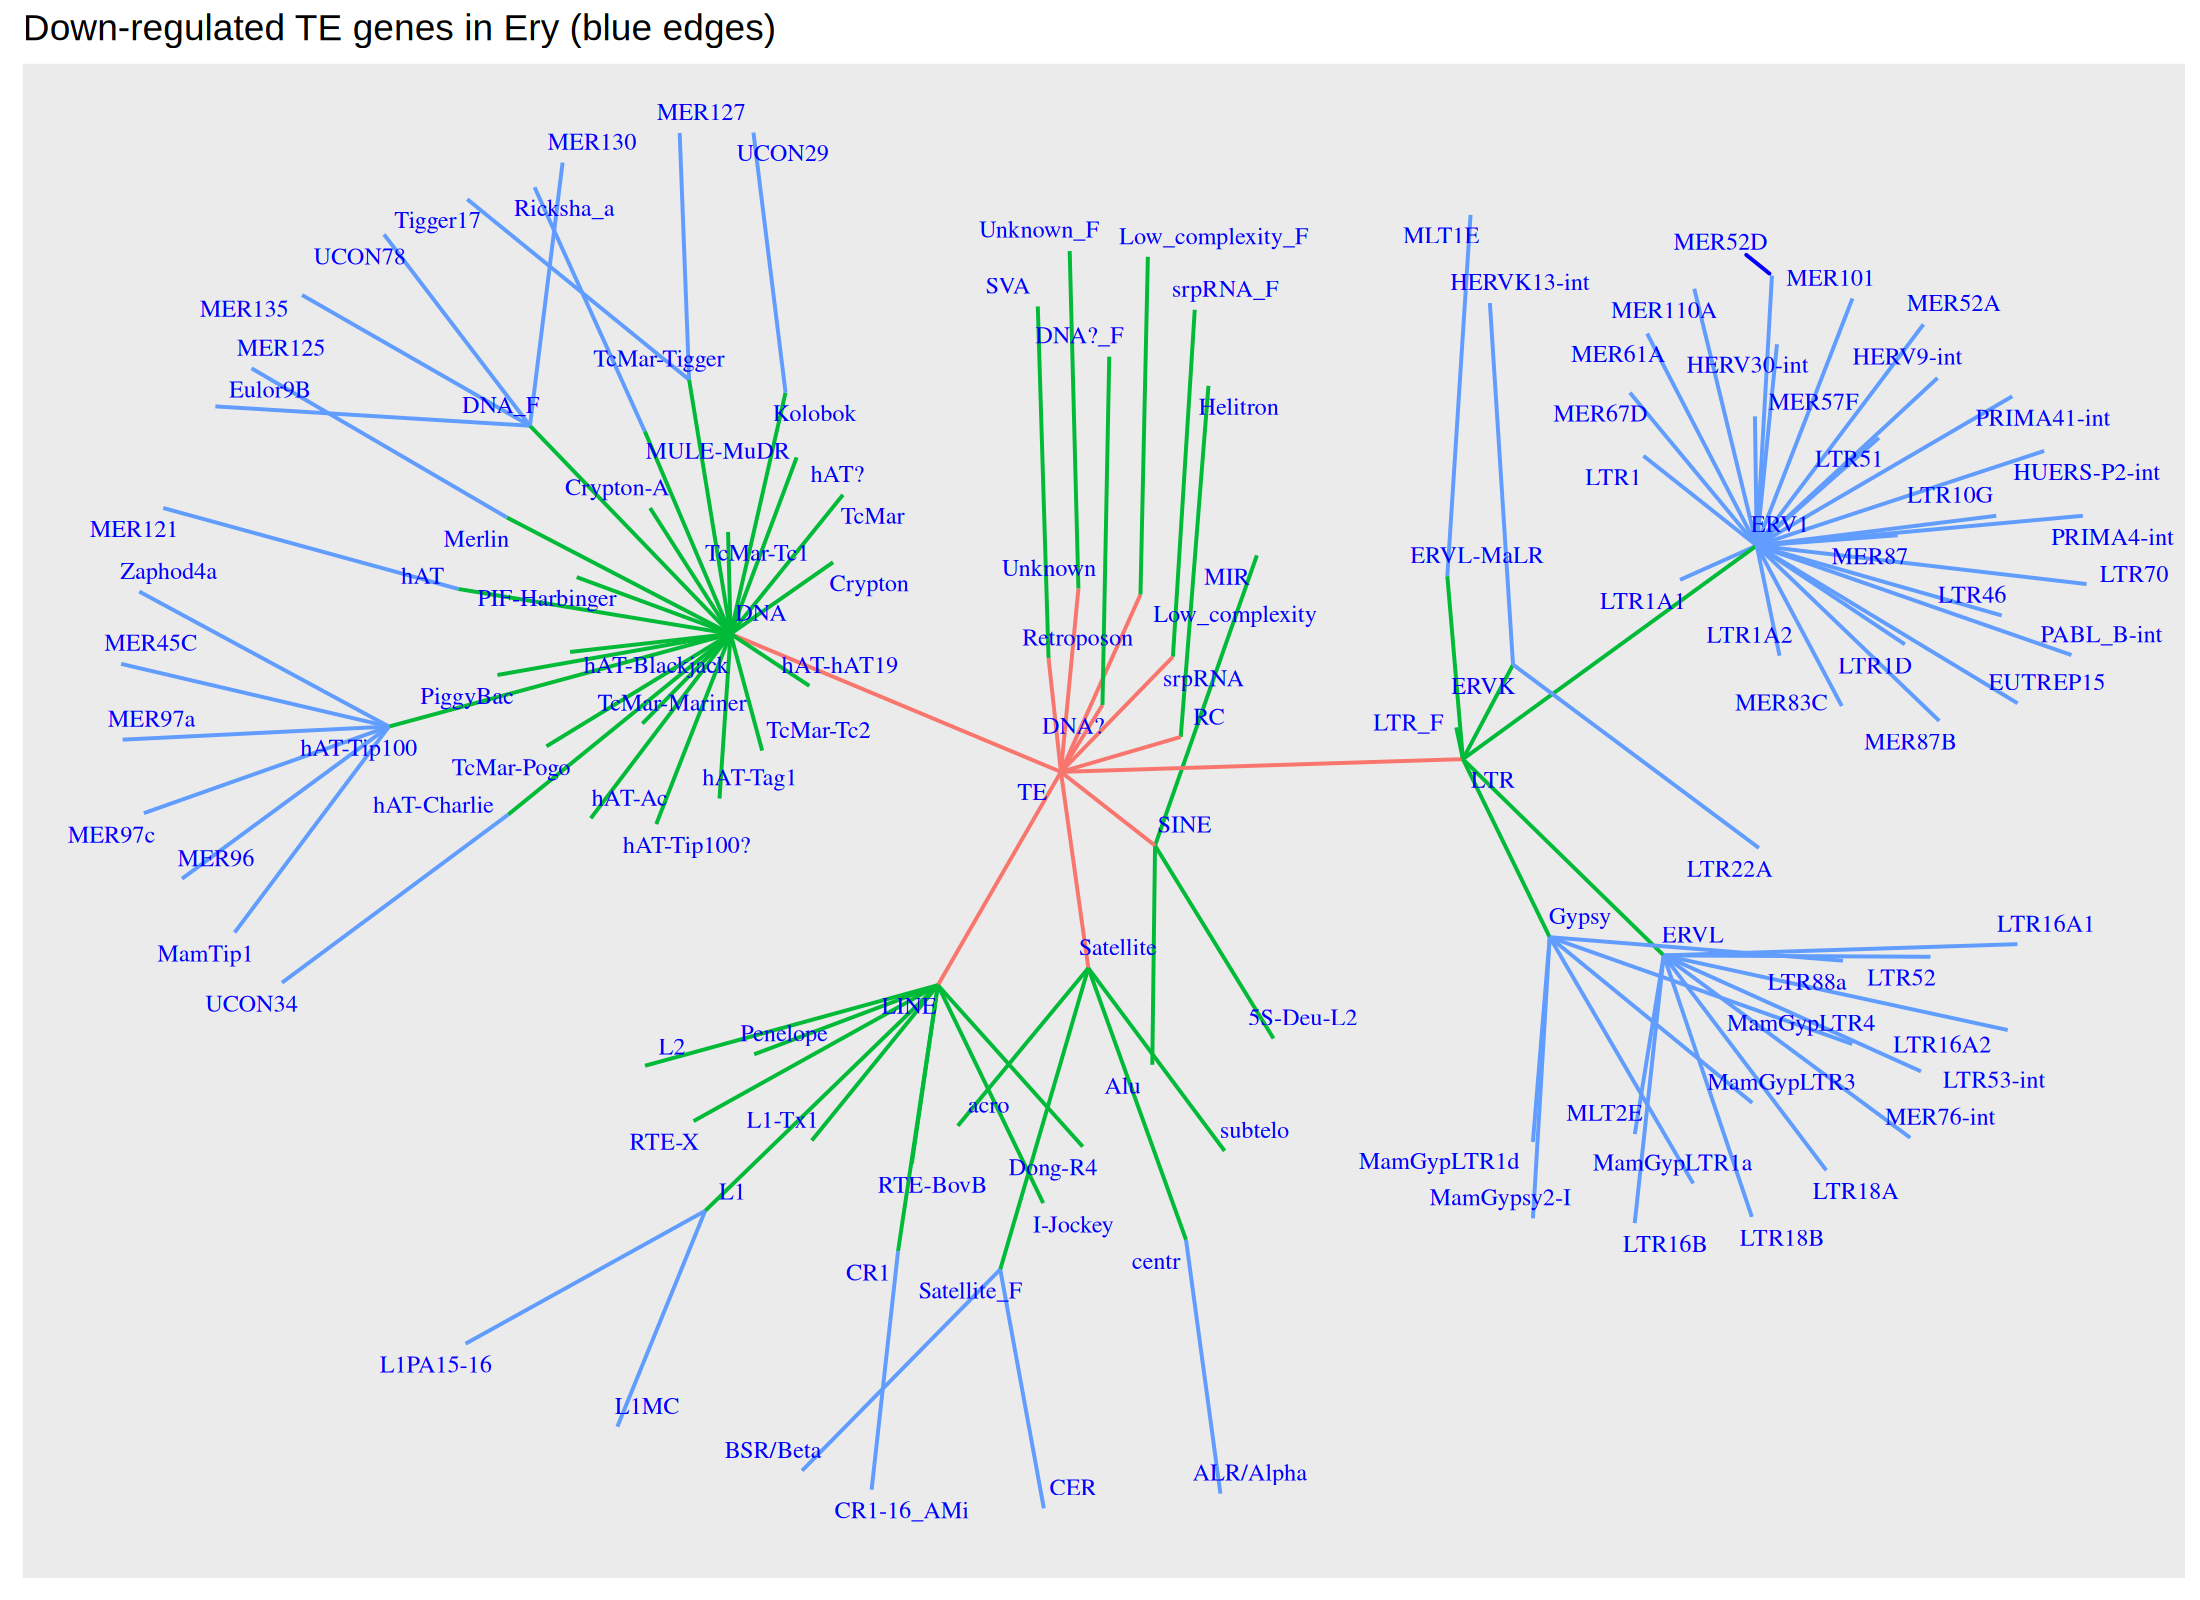

In [368]:
# down-regulated in Ery 
row_sel = deg_te_dt[logFC < -1 & FDR < 0.1 & .id == 'Ery', ]
row_sel_geneID = lapply(row_sel$rn, function(xx){unlist(strsplit(xx, ':'))[1]})

plotdat0 = graph_dt[lvl %in% c('lvl1', 'lvl2'), ]  
plotdat1 = graph_dt[to %in% row_sel_geneID,] 
plotdat  = rbind(plotdat0, plotdat1)
plotdat  = plotdat[!duplicated(to), ]
plotdat  = as_tbl_graph(plotdat)

options(repr.plot.width = 11, repr.plot.height = 8, repr.plot.res = 200)
ggraph(plotdat, layout = 'stress') +  geom_edge_link(aes(colour = factor(lvl))) +  #geom_node_point() + 
  geom_node_text(aes(label = name), repel = T, colour = 'blue', size=3, show.legend = FALSE, family = "serif") + theme(legend.position = "none") +
  ggtitle('Down-regulated TE genes in Ery (blue edges)')


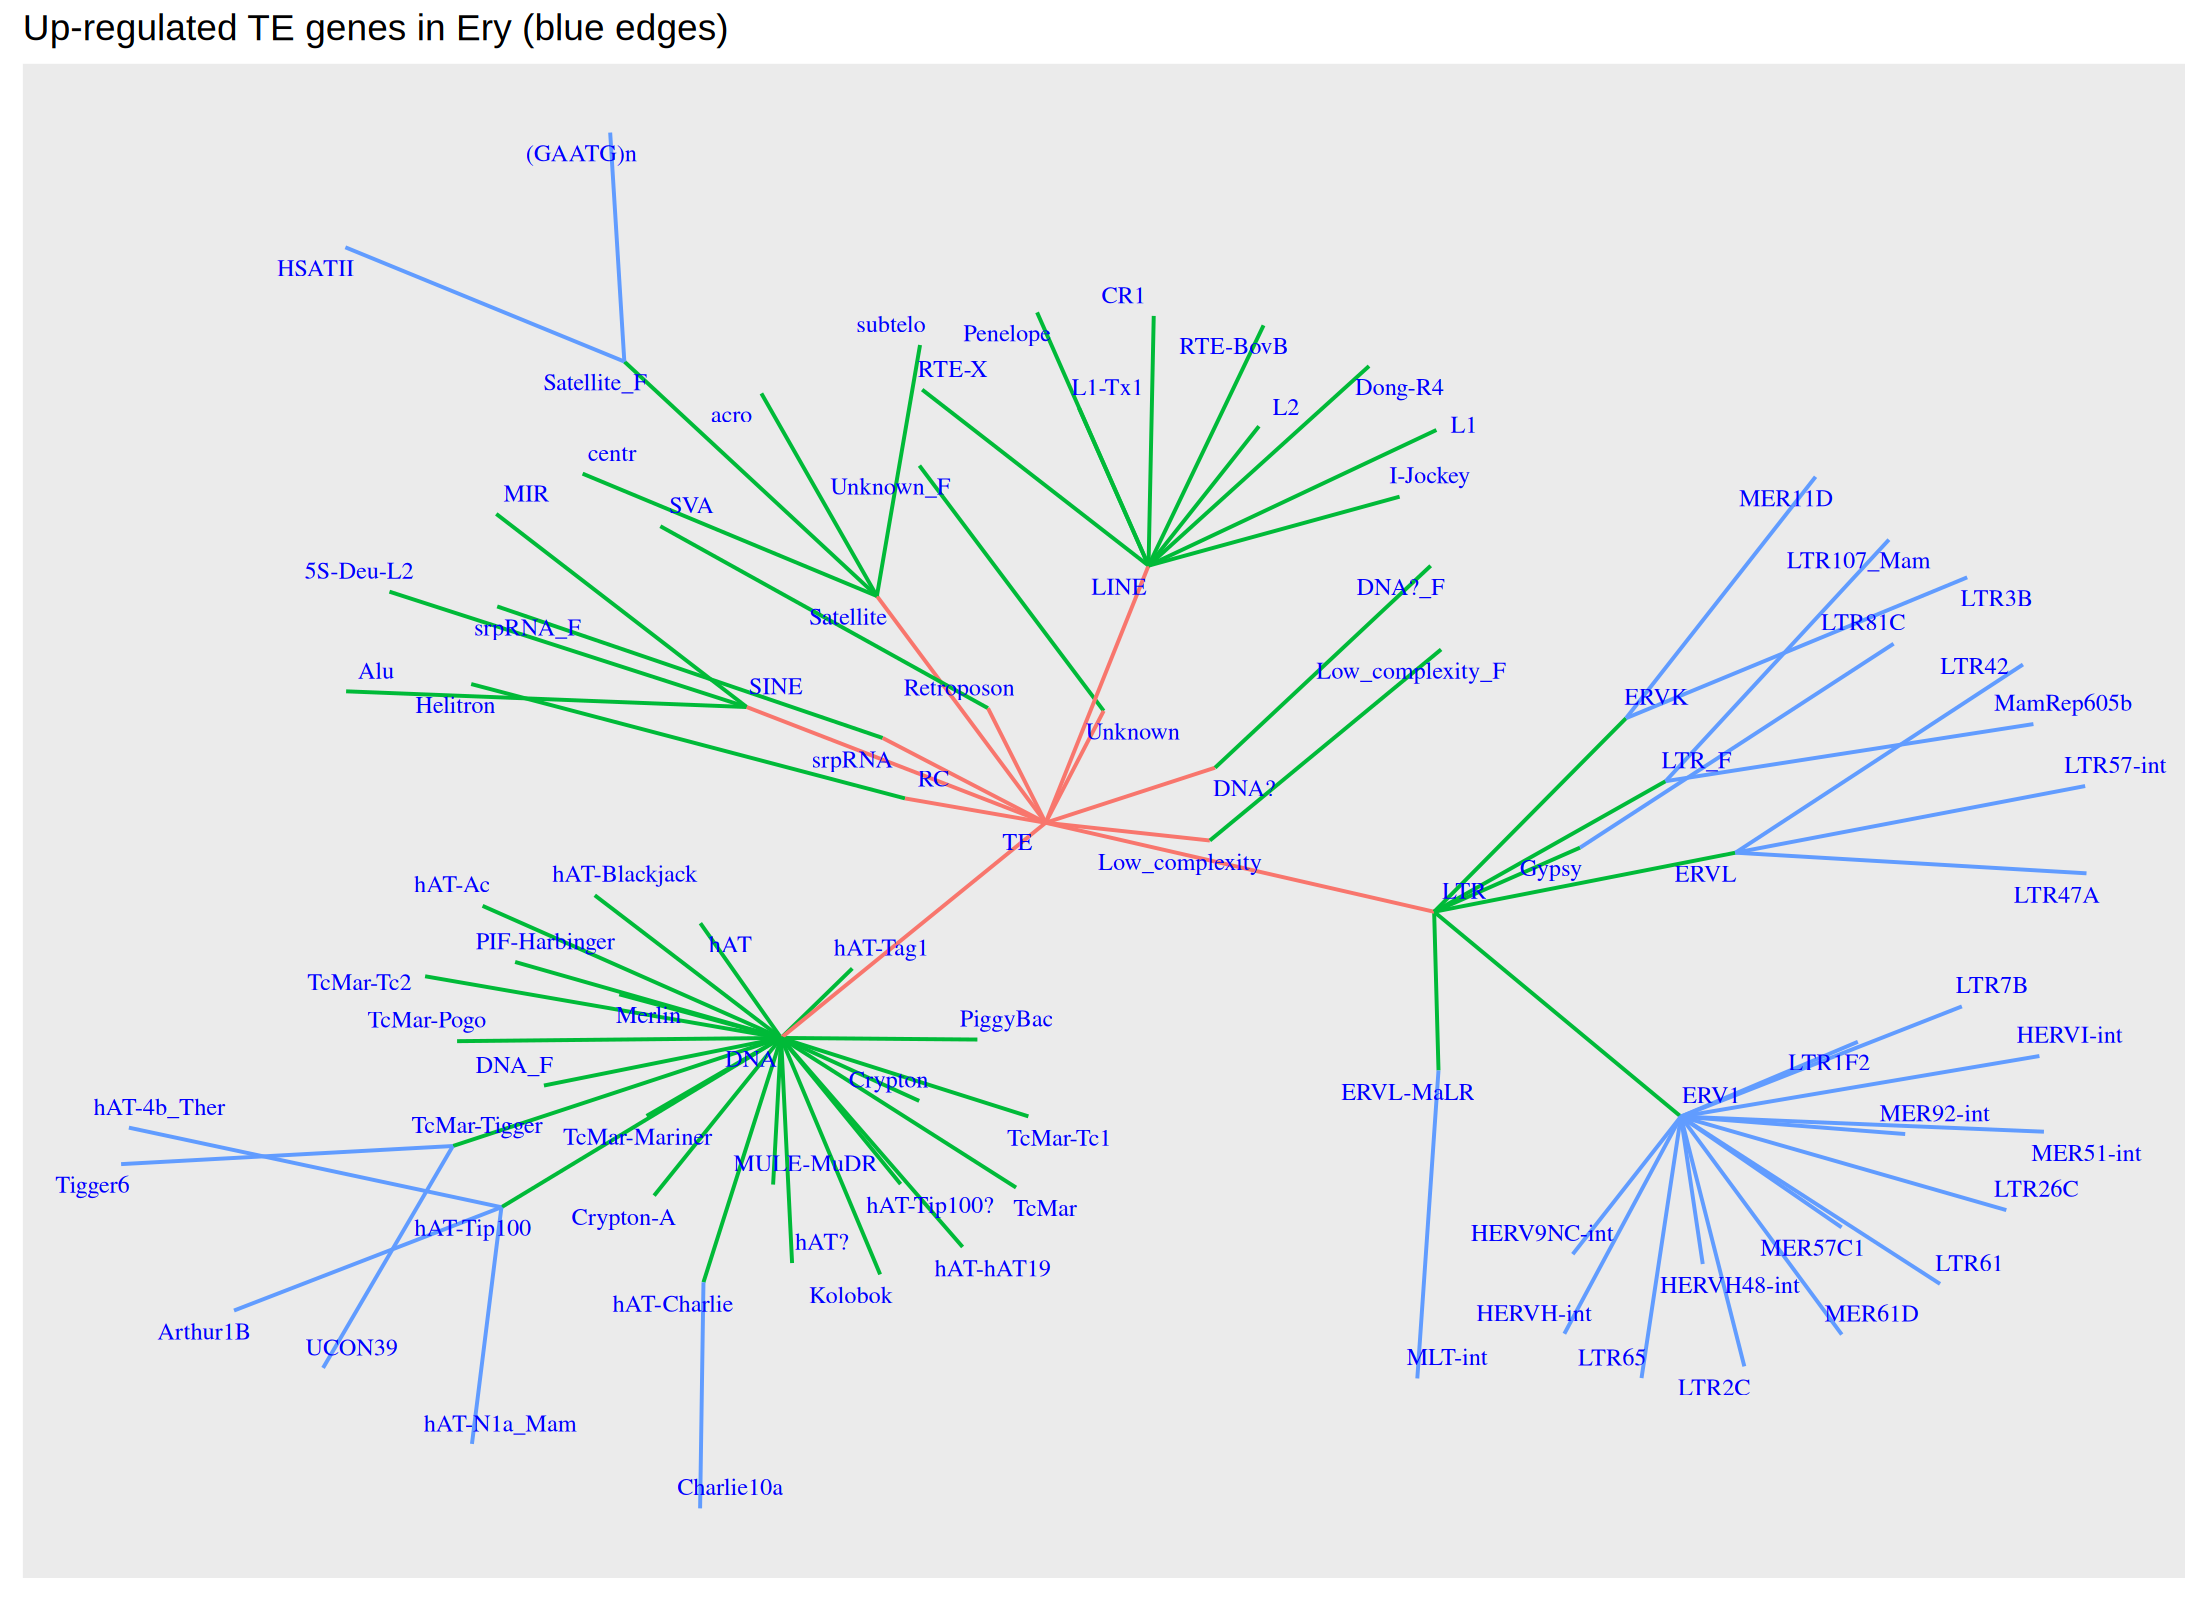

In [369]:
# up-regulated in Ery 
row_sel = deg_te_dt[logFC > 1 & FDR < 0.1 & .id == 'Ery', ]
row_sel_geneID = lapply(row_sel$rn, function(xx){unlist(strsplit(xx, ':'))[1]})

plotdat0 = graph_dt[lvl %in% c('lvl1', 'lvl2'), ]  
plotdat1 = graph_dt[to %in% row_sel_geneID,] 
plotdat  = rbind(plotdat0, plotdat1)
plotdat  = plotdat[!duplicated(to), ]
plotdat  = as_tbl_graph(plotdat)

options(repr.plot.width = 11, repr.plot.height = 8, repr.plot.res = 200)
ggraph(plotdat, layout = 'stress') +  geom_edge_link(aes(colour = factor(lvl))) +  #geom_node_point() + 
  geom_node_text(aes(label = name), repel = T, colour = 'blue', size=3, show.legend = FALSE, family = "serif") + theme(legend.position = "none") +
  ggtitle('Up-regulated TE genes in Ery (blue edges)')


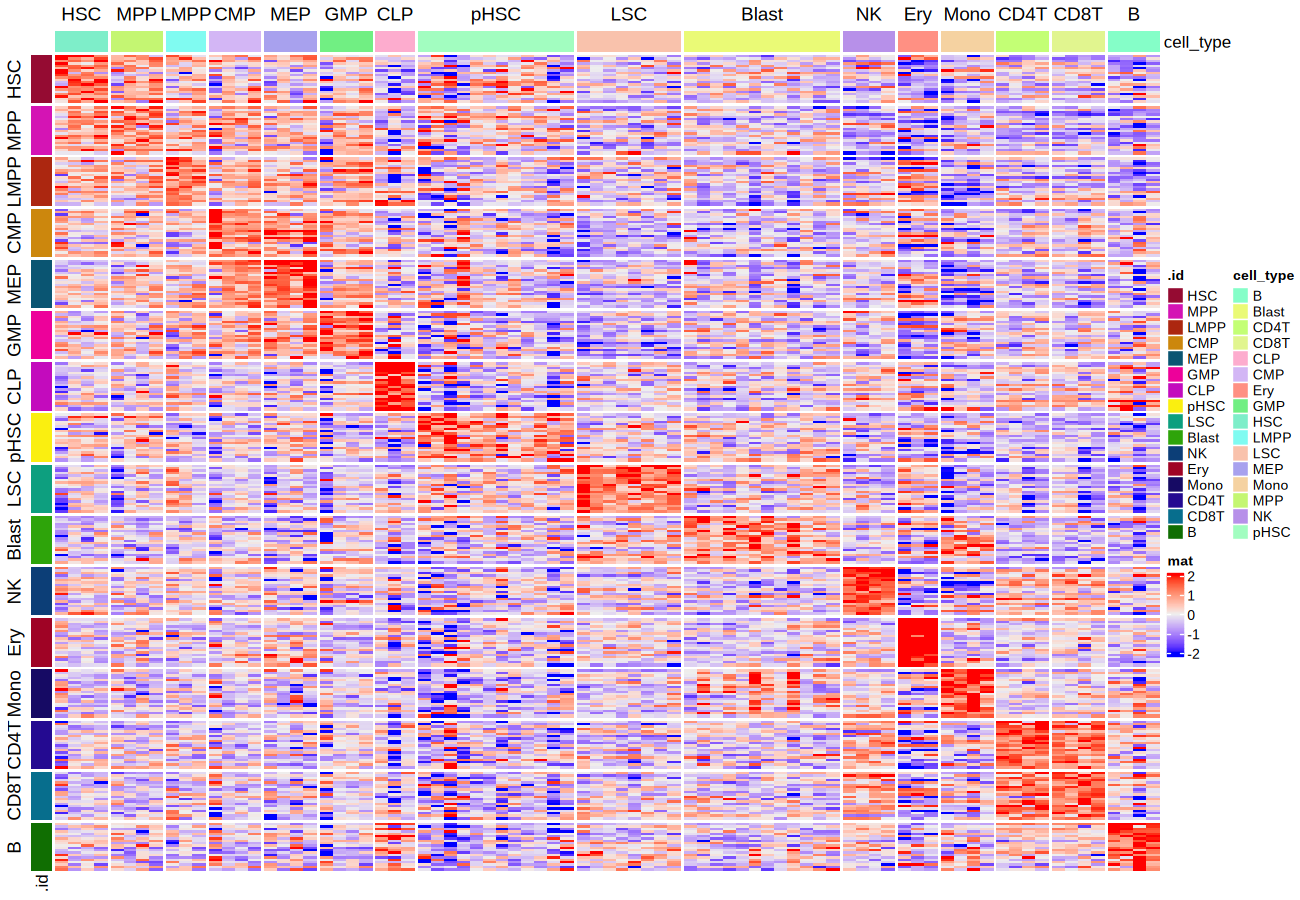

In [129]:
# top 20 up-regulated TE genes for each cell type
options(repr.plot.width = 13, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_te_dt[logFC > 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
#ov = intersect(row_sel$rn, rownames(logcpm_te))
#row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_te[row_sel$rn, dsn_sample$sample_name]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_sample[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_sample$cell_type, levels = cell_types))  


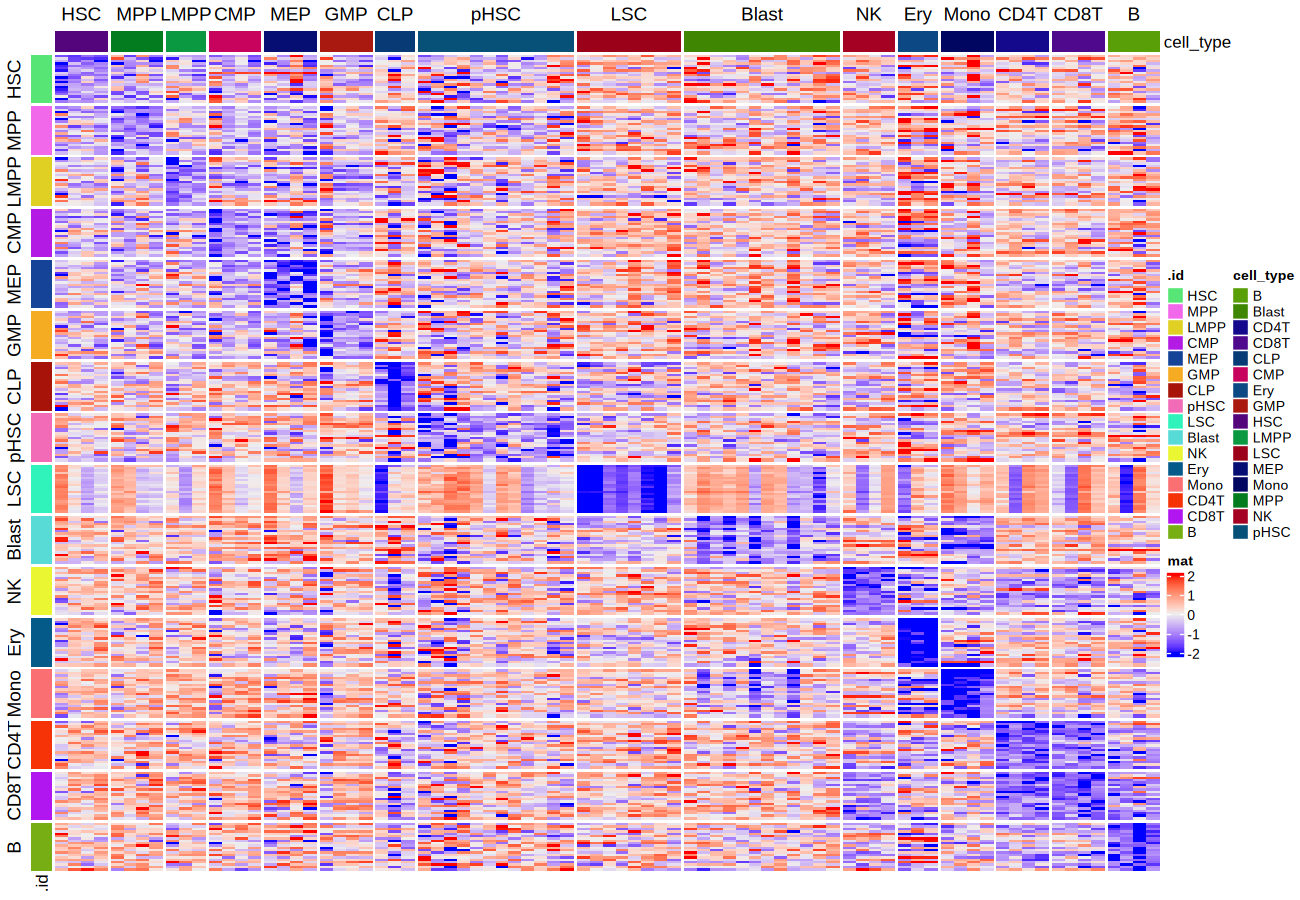

In [133]:
# top 20 down-regulated TE genes for each cell type
options(repr.plot.width = 13, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_te_dt[logFC < 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
#ov = intersect(row_sel$rn, rownames(logcpm_te))
#row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_te[row_sel$rn, dsn_sample$sample_name]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_sample[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_sample$cell_type, levels = cell_types))  


# examine the down-regulated TEs in CMP 

In [8]:
deg_telocal_MEPCMP = readRDS(file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/deg_telocal_MEPCMP.rds')
deg_MEPCMP = fread(file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/deg_MEPCMP15Jul.tsv')
sel = unique(deg_MEPCMP[batch == 'CMP' & logFC > 2 & FDR < 0.01, rn])
length(sel)
head(sel)


[1] 43

[1] "MER92D:ERV1:LTR"  "LTR53B:ERVL:LTR"  "L1P3b:L1:LINE"    "LTR35B:ERV1:LTR"  "Eulor8:TcMar:DNA" "LTR1B0:ERV1:LTR"

In [12]:
head2(logcpm_te)

D1022_B  D1022_CD4T D1022_CD8T D1022_NK D2596_B 
(GAATG)n:Satellite:Satellite 4.735376 4.243390   4.122256   4.794935 4.350590
ALR/Alpha:centr:Satellite    4.860747 4.589341   4.479855   4.323883 4.730196
Alu:Alu:SINE                 6.084528 5.904827   5.942804   6.030917 5.896804

In [ ]:
plotdat = logcpm_te[rownames(logcpm_te) %in% sel, dsn_sample$sample_name]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

options(repr.plot.width = 18, repr.plot.height = 3, repr.plot.res = 300)
column_ha = HeatmapAnnotation(df = dsn_sample[, 'cell_type', drop = F])
#column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = T, # row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, #left_annotation = column_ra, 
        column_split = factor(dsn_sample$cell_type))  


In [21]:
unique(dsn_sample$cell_type)

[1] B     CD4T  CD8T  NK    CLP   Ery   LMPP  CMP   GMP   HSC   MEP   MPP   Mono  Blast pHSC  LSC  
Levels: HSC MPP LMPP CMP MEP GMP CLP pHSC LSC Blast NK Ery Mono CD4T CD8T B

In [20]:
cell_types

[1] "HSC" "MPP" "CMP" "GMP" "MEP" "CLP" "EB"  "MK"

In [19]:
dsn_sample[, 'cell_type', drop = F]

cell_type
D1022_B     B        
D1022_CD4T  CD4T     
D1022_CD8T  CD8T     
D1022_NK    NK       
D2596_B     B        
D2596_CD4T  CD4T     
D2596_CD8T  CD8T     
D2596_CLP   CLP      
D2596_Ery   Ery      
D2596_NK    NK       
D5483_CLP   CLP      
D5483_Ery   Ery      
D5483_LMPP  LMPP     
D5483_NK    NK       
D5852_B     B        
D5852_CD4T  CD4T     
D5852_CD8T  CD8T     
D5852_CMP   CMP      
D5852_GMP   GMP      
D5852_HSC   HSC      
D5852_MEP   MEP      
D5852_MPP   MPP      
D5852_Mono  Mono     
D6792_CMP   CMP      
D6792_GMP   GMP      
D6792_HSC   HSC      
D6792_MEP   MEP      
D6792_MPP   MPP      
D6792_Mono  Mono     
D6926_CLP   CLP      
⋮           ⋮        
SU070_Blast Blast    
SU070_LSC   LSC      
SU070_pHSC  pHSC     
SU209_Blast Blast    
SU209_LSC   LSC      
SU209_pHSC  pHSC     
SU351_Blast Blast    
SU351_pHSC  pHSC     
SU353_Blast Blast    
SU353_LSC   LSC      
SU353_pHSC  pHSC     
SU444_Blast Blast    
SU444_LSC   LSC      
SU444_pHSC  pHSC     
SU484_Blast Blast    
SU484_pHSC  pHSC     
SU496_Blast Blast    
SU496_LSC   LSC      
SU496_pHSC  pHSC     
SU501_Blast Blast    
SU501_pHSC  pHSC     
SU575_Blast Blast    
SU575_LSC   LSC      
SU575_pHSC  pHSC     
SU583_Blast Blast    
SU583_LSC   LSC      
SU583_pHSC  pHSC     
SU654_Blast Blast    
SU654_LSC   LSC      
SU654_pHSC  pHSC

# heatmap for TE genes, HSPC only

[1] 57  7

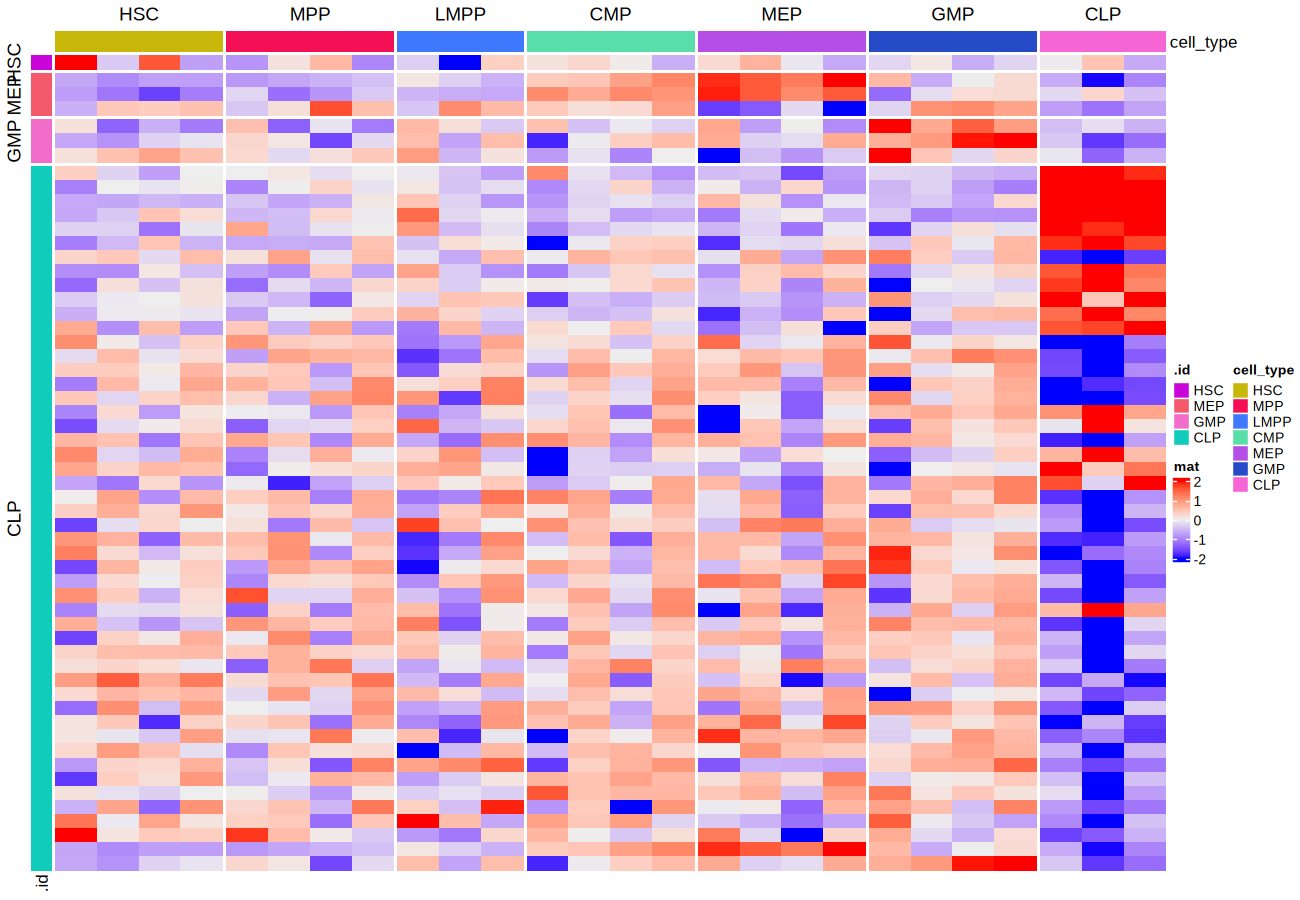

In [364]:
# significant TEs
options(repr.plot.width = 13, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_te_dt_hspc[abs(logFC) > 1 & FDR < 0.1, ]
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
dim(row_sel)

plotdat = logcpm_te_hspc[row_sel$rn, dsn_sample_hspc$sample_name]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_sample_hspc[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_sample_hspc$cell_type, levels = cell_types))  


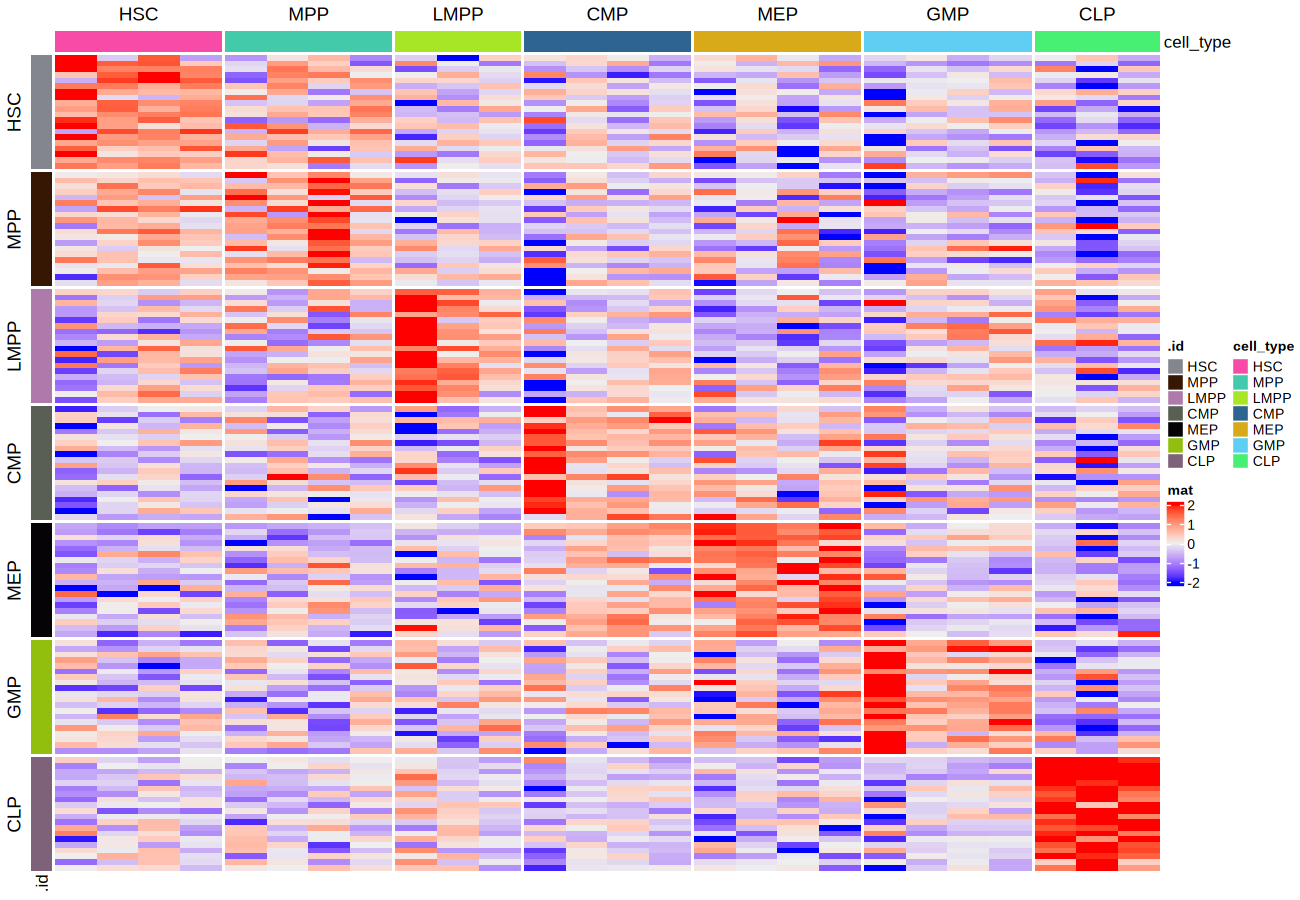

In [365]:
# top 20 up-regulated TE genes for each cell type
options(repr.plot.width = 13, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_te_dt_hspc[logFC > 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
#ov = intersect(row_sel$rn, rownames(logcpm_te))
#row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_te_hspc[row_sel$rn, dsn_sample_hspc$sample_name]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_sample_hspc[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_sample_hspc$cell_type, levels = cell_types))  


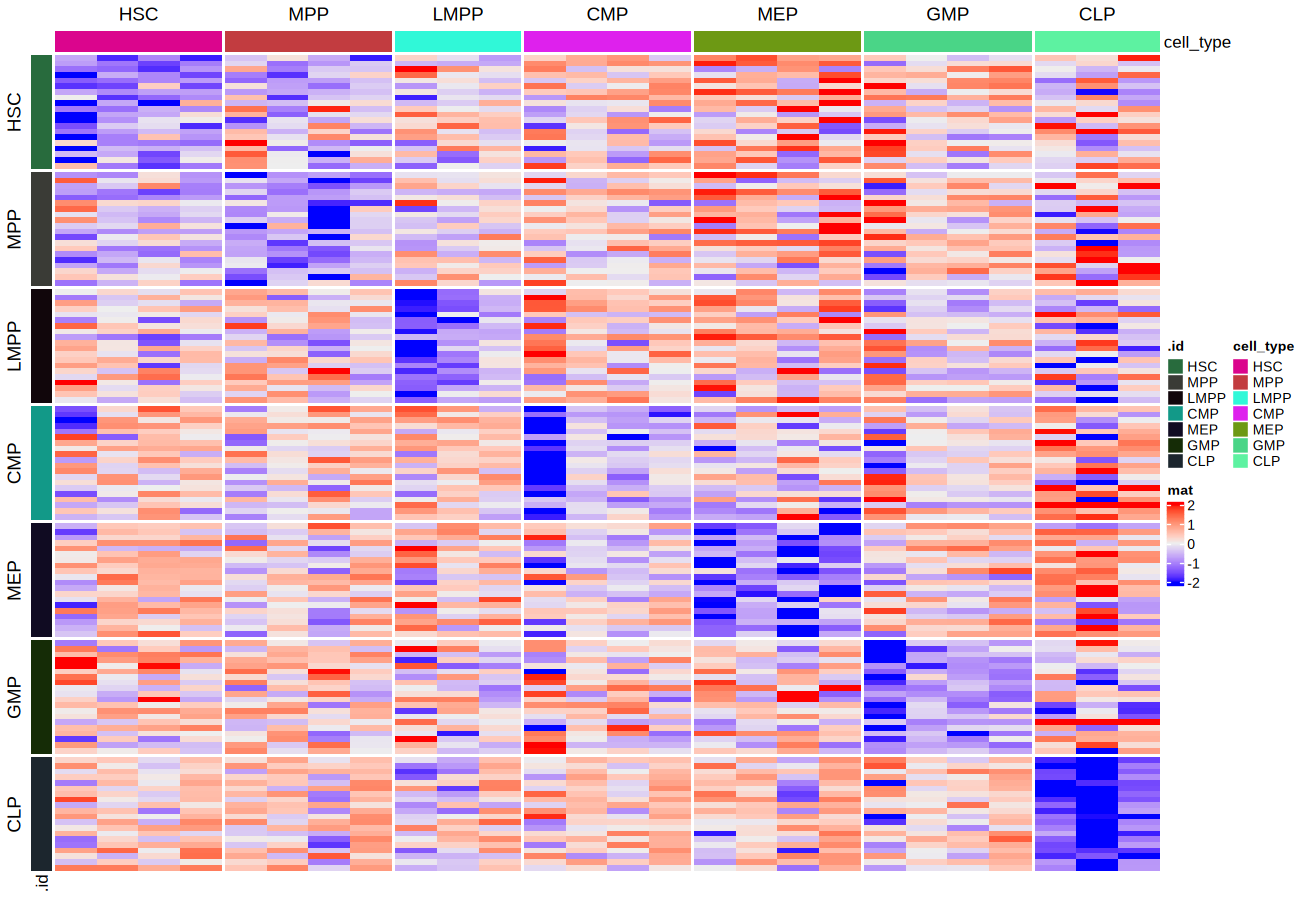

In [366]:
# top 20 down-regulated TE genes for each cell type
options(repr.plot.width = 13, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_te_dt_hspc[logFC < 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
#ov = intersect(row_sel$rn, rownames(logcpm_te))
#row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_te_hspc[row_sel$rn, dsn_sample_hspc$sample_name]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_sample_hspc[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_sample_hspc$cell_type, levels = cell_types))  


# export 

In [4]:
load('nb_ranseq_resource_list.rdata')

In [379]:
save.image(file = 'nb_ranseq_resource_list.rdata')

In [5]:
dsn_sample_dt[, sample_name2 := paste0(sample_name, '_rep', 1:nrow(.SD)), by = 'sample_name']

In [31]:
tecount_mtx = tecount_mtx[, dsn_sample_dt$sample_name] 


In [32]:
colnames(tecount_mtx) = dsn_sample_dt$sample_name2

In [28]:
write.table(dsn_sample_dt, file = 'dsn_sample_RNASeq_batch2_dt.tsv', sep = '\t')


In [6]:
dsn_sample_dt = fread('dsn_sample_RNASeq_batch2_dt.tsv')

Warning message in fread("dsn_sample_RNASeq_batch2_dt.tsv"):
“Detected 60 column names but the data has 61 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [17]:
head(dsn_sample_dt[, .(sample_name, cell_type, sample_dir, tecount_file, telocal_file)])


sample_name cell_type sample_dir                                                                                    
1 D1022_B     B         /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_B/   
2 D1022_CD4T  CD4T      /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_CD4T/
3 D1022_CD8T  CD8T      /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_CD8T/
4 D1022_NK    NK        /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_NK/  
5 D2596_B     B         /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D2596_B/   
6 D2596_CD4T  CD4T      /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D2596_CD4T/
  tecount_file                                                                                                   
1 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_B//tecount.cntTable   
2 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_CD4T//tecount.cntTable
3 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_CD8T//tecount.cntTable
4 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_NK//tecount.cntTable  
5 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D2596_B//tecount.cntTable   
6 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D2596_CD4T//tecount.cntTable
  telocal_file                                                                                                  
1 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_B//rnaseq.cntTable   
2 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_CD4T//rnaseq.cntTable
3 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_CD8T//rnaseq.cntTable
4 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D1022_NK//rnaseq.cntTable  
5 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D2596_B//rnaseq.cntTable   
6 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/TE/rnaseq/D2596_CD4T//rnaseq.cntTable

In [29]:
head(tecount_mtx)

D1022_B D1022_CD4T D1022_CD8T D1022_NK D2596_B D2596_CD4T D2596_CD8T D2596_CLP D2596_Ery D2596_NK ⋯ SU501_pHSC SU575_Blast SU575_LSC SU575_pHSC
(CATTC)n:Satellite:Satellite          53      56         48         74      137      60         66         60        80        68      ⋯ 11          61          91       40        
(GAATG)n:Satellite:Satellite         141     155        119        132      310     128        159        130       196       191      ⋯ 23         108         204       92        
7SLRNA:srpRNA:srpRNA                   6       0          1          0       10       0          1          1         0         0      ⋯  0           1           1        1        
A-rich:Low_complexity:Low_complexity   0       0          0          0        0       0          0          0         1         0      ⋯  0           0           0        0        
A1BG                                   3       6          2          1        6       2          5         21         1         0      ⋯  3           1           1       11        
A1BG-AS1                              12      12          5          2        6       6          9          7         0         4      ⋯  1           8           3        4        
                                     SU583_Blast SU583_LSC SU583_pHSC SU654_Blast SU654_LSC SU654_pHSC
(CATTC)n:Satellite:Satellite         18          27         9         25          103       25        
(GAATG)n:Satellite:Satellite         47          60        15         64          182       19        
7SLRNA:srpRNA:srpRNA                  1           9         0          1            6        0        
A-rich:Low_complexity:Low_complexity  1           0         0          1            0        0        
A1BG                                  0           1         0          0            1       10        
A1BG-AS1                              1           3         0          7            7        2

In [24]:
table(dsn_sample_dt$cell_type)


    B Blast  CD4T  CD8T   CLP   CMP   Ery   GMP   HSC  LMPP   LSC   MEP  Mono   MPP    NK  pHSC 
    4    12     4     4     3     4     3     4     4     3     8     4     4     4     4    12 

In [33]:
write.table(tecount_mtx, file = 'tecount_mtx_batch2.tsv', sep = '\t')

In [11]:
dim(tecount_mtx)

[1] 58824    81

In [7]:
load('nb_ranseq_resource_list.rdata')